In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

bif_c = 0.1
num_iter_max=200000
alpha=0.2
# alpha=0.5
# alpha=0.8 # predict diverge
# vae_lr=1e-5
vae_lr=5e-4
ratio_lr=5e-4
ratio_early=100
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_pendulum_A_"

loss_list = []
normalized_loss_list = []

In [2]:
import gym
import custom_gym
env = gym.make(env_name)

seed = 0
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = 1
print(s_dim, a_dim, z_dim)



2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_pendulum_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data.pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info.pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_standardvae_


In [4]:
args_init_dict = {"offline_data": offline_data,
             "s_dim": s_dim,
             "a_dim": a_dim,
             "z_dim": z_dim,
#              "policy":agent.select_action,
             "mdp_policy":None,
             "bamdp_policy":agent.policy.my_np_select_action,
                  "debug_info":debug_info,
                  "env" : env}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base()
iwvi.update_mulogvar_offlinedata()

load vi_base_ckpt


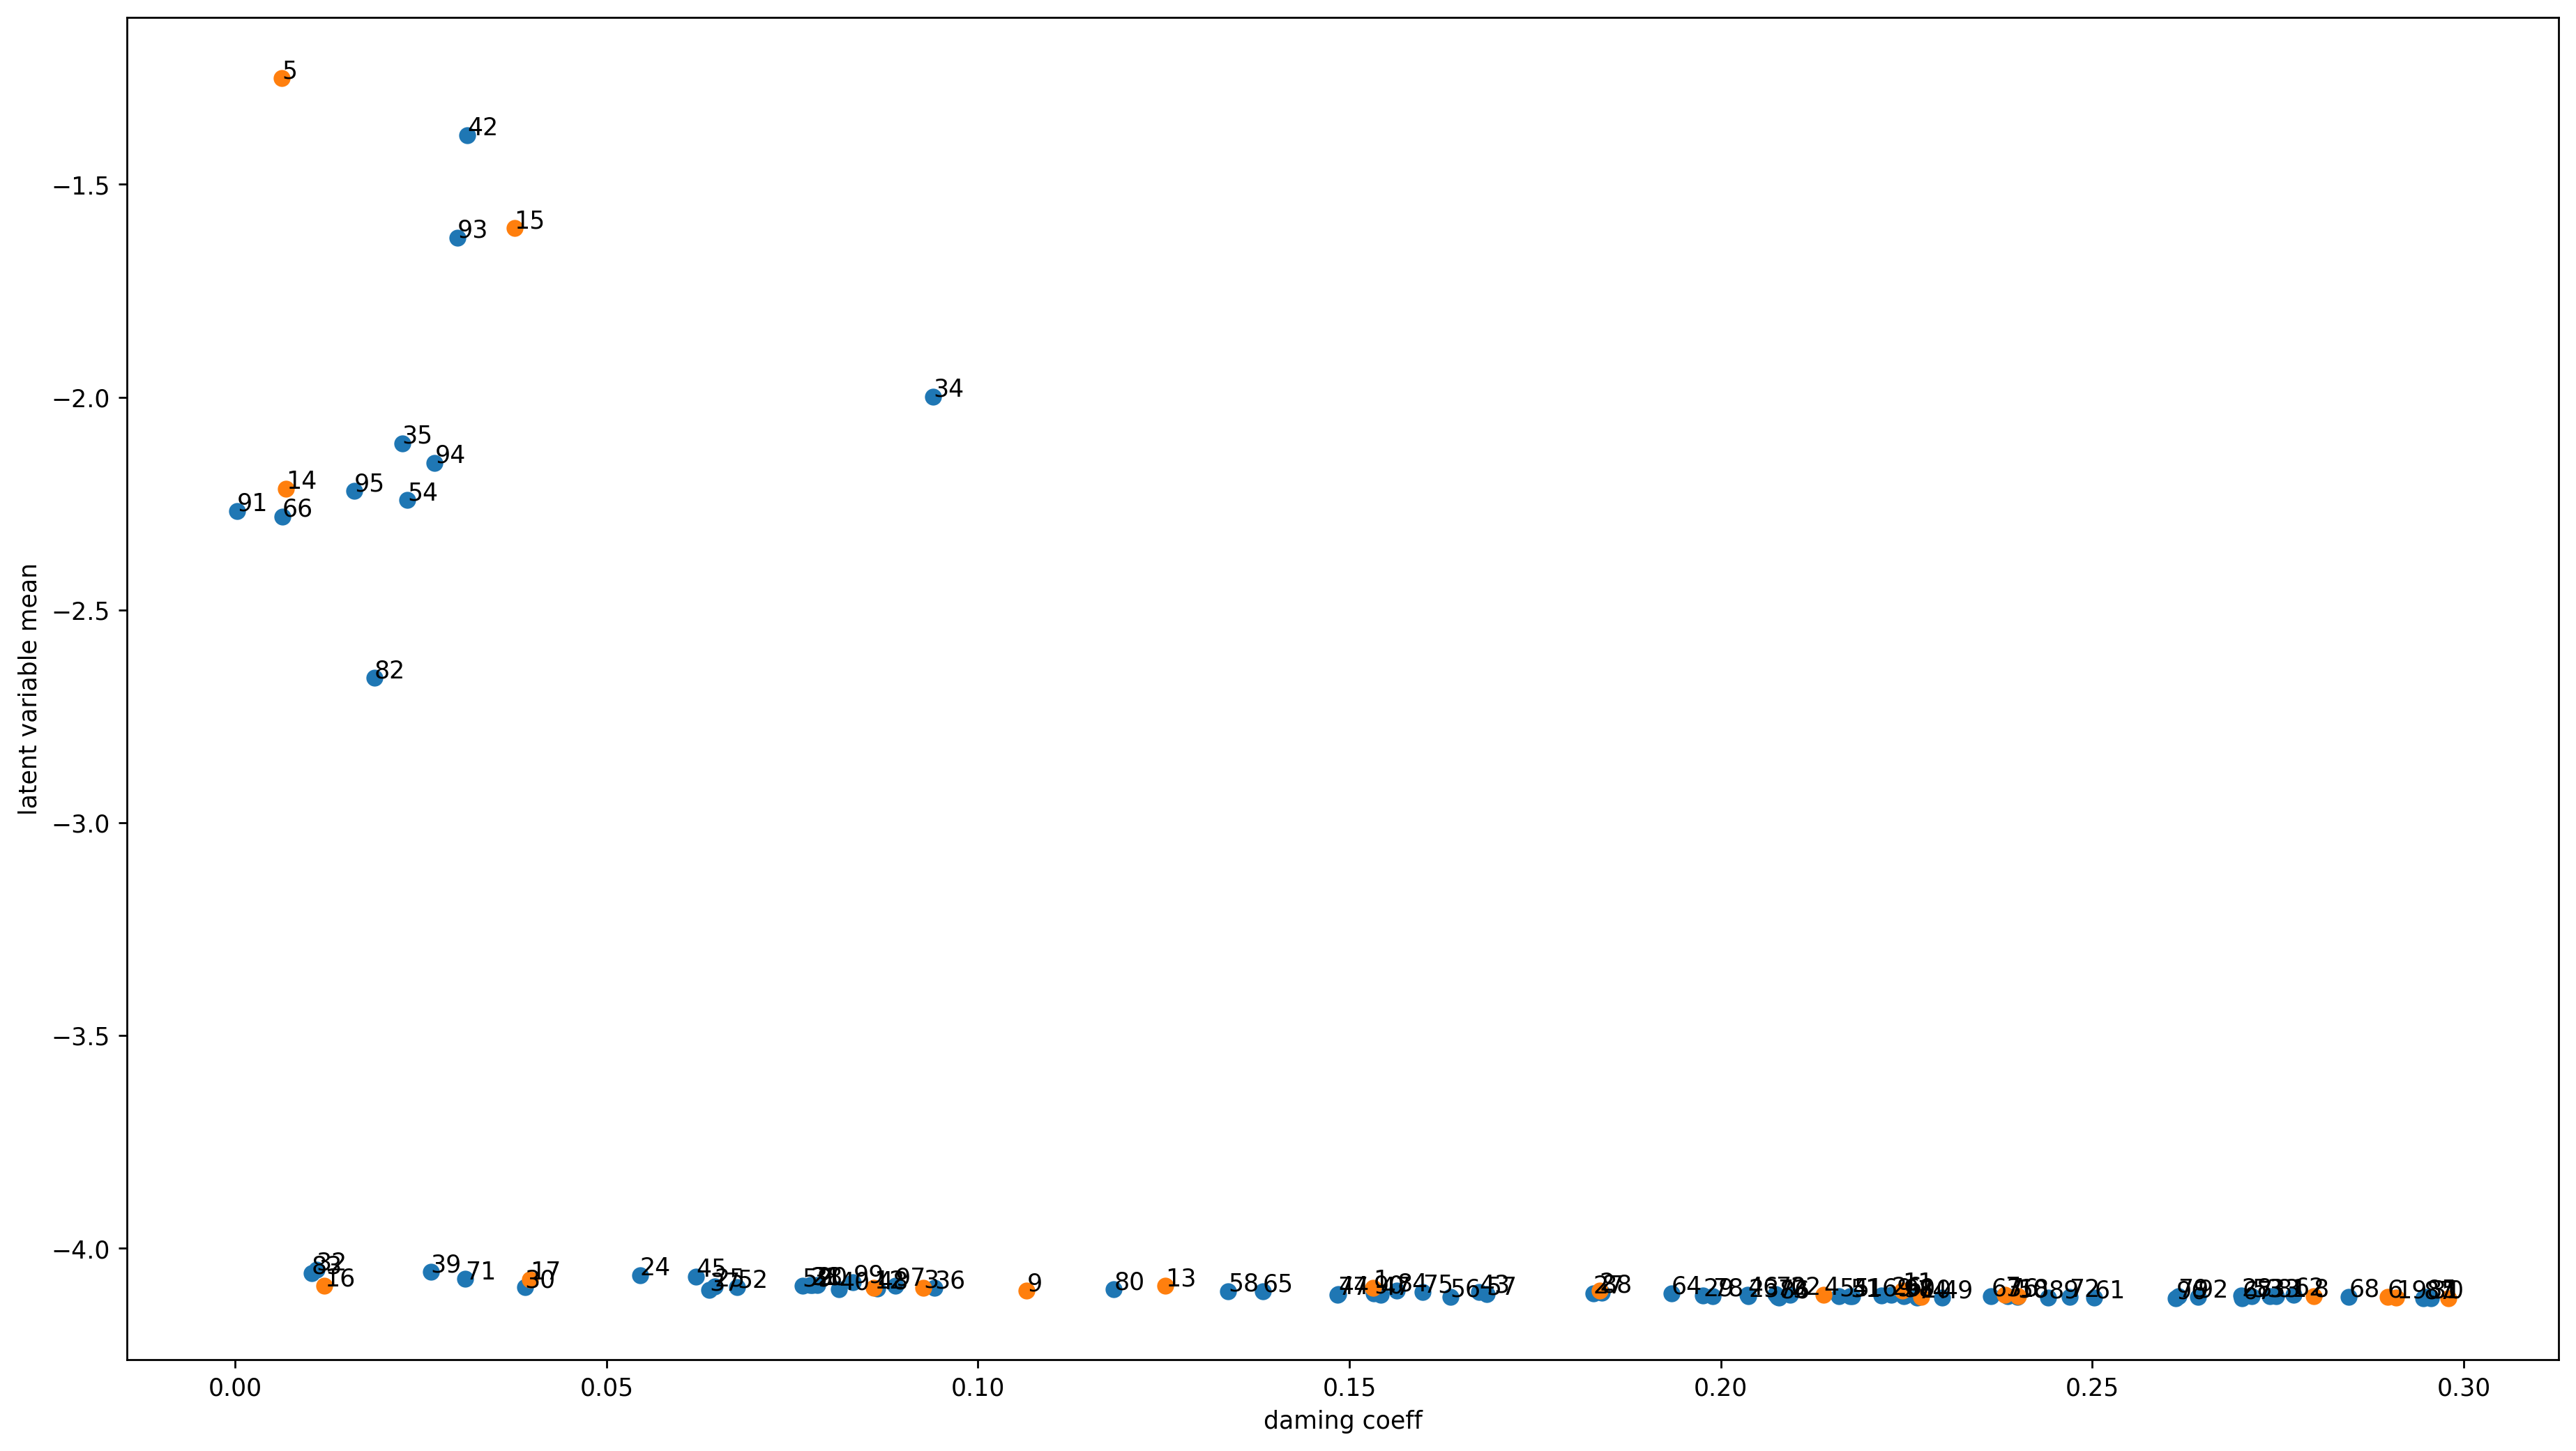

[0.29791016 0.15322083 0.18365987 0.09261918 0.21384459 0.00627838
 0.28977922 0.23826577 0.27982297 0.10656002]
[0.22693388 0.2244697  0.08596681 0.12522523 0.00685178 0.03757813
 0.01196297 0.03966669 0.24002473 0.29092061]
[0.07835583 0.07746172 0.20934208 0.20371297 0.05450337 0.06451795
 0.2229776  0.1828022  0.27007945 0.19762321]
[0.03898917 0.29555121 0.01093391 0.27386888 0.09397505 0.02248499
 0.09414549 0.06385285 0.07767223 0.02632497]
[0.08125716 0.21770374 0.03126921 0.1674378  0.14847363 0.06205282
 0.20363688 0.15417275 0.08645989 0.22978046]
[0.23991758 0.21743357 0.06757306 0.2714981  0.02319353 0.21589278
 0.16356097 0.16844176 0.13367955 0.07634676]
[0.22476822 0.25029279 0.2771417  0.23638723 0.19333075 0.13834196
 0.00632632 0.27019082 0.28455401 0.22163373]
[0.20737241 0.03096922 0.24692379 0.20760993 0.22644138 0.1598574
 0.23863549 0.1484238  0.19891706 0.26157098]
[0.11830818 0.27478066 0.01872246 0.01027625 0.15642099 0.29498274
 0.20786144 0.29459763 0.18393

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_iter0.eps")
plt.savefig(figfilenamehead+"damping_latent_iter0.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.xlim([0.06,0.14])
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ

get_belief:  [ -4.138723 -10.138827] iter 94 len 200 compute_time 0.0678 best_loss -688 loss.item() -688          
 1
get_belief:  [-4.100399 -9.00444 ] iter 108 len 200 compute_time 0.0775 best_loss -929 loss.item() -926          
 2
get_belief:  [-4.1084256 -8.410791 ] iter 72 len 200 compute_time 0.0525 best_loss -924 loss.item() -905         
 3
get_belief:  [-4.090089 -9.235302] iter 58 len 200 compute_time 0.042 best_loss -825 loss.item() -823           
 4
get_belief:  [-4.118831 -8.548778] iter 67 len 200 compute_time 0.0488 best_loss -909 loss.item() -909          
 5
get_belief:  [-2.5206223 -8.045952 ] iter 120 len 200 compute_time 0.0822 best_loss -578 loss.item() -575        
 6
get_belief:  [-4.1332726 -9.936787 ] iter 100 len 200 compute_time 0.0718 best_loss -720 loss.item() -719        
 7
get_belief:  [-4.124039 -9.680973] iter 68 len 200 compute_time 0.0497 best_loss -874 loss.item() -873          
 8
get_belief:  [-4.1344295 -9.753779 ] iter 58 len 200 compute_time 

get_belief:  [-4.12013  -9.940632] iter 55 len 200 compute_time 0.0414 best_loss -903 loss.item() -903            
 70
get_belief:  [ -4.116592 -10.021615] iter 63 len 200 compute_time 0.0456 best_loss -918 loss.item() -918          
 71
get_belief:  [-4.066128  -9.8017645] iter 57 len 200 compute_time 0.0415 best_loss -571 loss.item() -565         
 72
get_belief:  [ -4.128959 -10.045864] iter 61 len 200 compute_time 0.0445 best_loss -856 loss.item() -855          
 73
get_belief:  [ -4.121801 -10.147508] iter 60 len 200 compute_time 0.0441 best_loss -920 loss.item() -920          
 74
get_belief:  [ -4.122725  -10.2424755] iter 52 len 200 compute_time 0.0395 best_loss -895 loss.item() -895        
 75
get_belief:  [ -4.0999017 -10.102067 ] iter 71 len 200 compute_time 0.0522 best_loss -936 loss.item() -935        
 76
get_belief:  [ -4.1293936 -10.277272 ] iter 53 len 200 compute_time 0.0387 best_loss -876 loss.item() -873        
 77
get_belief:  [ -4.0946555 -10.174314 ] iter 79 le

In [7]:
# fig = plt.figure(figsize=(18,10))
# ax_list = []
# for i in range(50):
#     ax_list.append(fig.add_subplot(5, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1]) 
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1]) 
# print("オフラインデータvs実環境方策rollout")


 0
get_belief:  [ -4.081194 -10.071937] iter 67 len 200 compute_time 0.0485 best_loss -779 loss.item() -779          
 1
get_belief:  [ -4.1233606 -10.189076 ] iter 73 len 200 compute_time 0.0532 best_loss -796 loss.item() -795        
 2
get_belief:  [ -4.139187 -10.174725] iter 51 len 200 compute_time 0.0372 best_loss -805 loss.item() -804          
 3
get_belief:  [ -4.1294546 -10.063456 ] iter 70 len 200 compute_time 0.0514 best_loss -750 loss.item() -749        
 4
get_belief:  [ -4.086371 -10.10834 ] iter 111 len 200 compute_time 0.102 best_loss -777 loss.item() -777          
 5
get_belief:  [-1.2873778 -6.9457664] iter 118 len 200 compute_time 0.0827 best_loss -11.9 loss.item() -11.7         
 6
get_belief:  [-4.0917015 -9.808132 ] iter 62 len 200 compute_time 0.0448 best_loss -781 loss.item() -781          
 7
get_belief:  [ -4.132068 -10.269808] iter 60 len 200 compute_time 0.0439 best_loss -794 loss.item() -794          
 8
get_belief:  [ -4.0979095 -10.078009 ] iter 59 len

get_belief:  [-4.034556 -9.901675] iter 58 len 200 compute_time 0.0422 best_loss -786 loss.item() -782           
 70
get_belief:  [ -4.1389484 -10.103782 ] iter 80 len 200 compute_time 0.0583 best_loss -818 loss.item() -817        
 71
get_belief:  [-4.057952  -9.9457655] iter 67 len 200 compute_time 0.0485 best_loss -778 loss.item() -778         
 72
get_belief:  [ -4.127551 -10.137747] iter 65 len 200 compute_time 0.0476 best_loss -804 loss.item() -804         
 73
get_belief:  [ -4.064573 -10.032118] iter 53 len 200 compute_time 0.0402 best_loss -769 loss.item() -769          
 74
get_belief:  [ -4.1193357 -10.116326 ] iter 54 len 200 compute_time 0.0402 best_loss -773 loss.item() -773        
 75
get_belief:  [ -4.1318855 -10.161944 ] iter 113 len 200 compute_time 0.0807 best_loss -792 loss.item() -792       
 76
get_belief:  [-4.0727887 -9.98359  ] iter 54 len 200 compute_time 0.0393 best_loss -770 loss.item() -768          
 77
get_belief:  [ -4.0585146 -10.086193 ] iter 66 len 

get_belief:  [ -4.1451664 -10.311596 ] iter 71 len 200 compute_time 0.0515 best_loss -796 loss.item() -795        
 39
get_belief:  [ -4.113848 -10.211151] iter 70 len 200 compute_time 0.0512 best_loss -809 loss.item() -808          
 40
get_belief:  [ -4.0999675 -10.146849 ] iter 57 len 200 compute_time 0.041 best_loss -787 loss.item() -787         
 41
get_belief:  [ -4.125476 -10.261675] iter 51 len 200 compute_time 0.0371 best_loss -765 loss.item() -765          
 42
get_belief:  [-1.2610918 -6.886581 ] iter 59 len 200 compute_time 0.0431 best_loss 4.19 loss.item() 5.91            
 43
get_belief:  [ -4.057191 -10.111131] iter 62 len 200 compute_time 0.0454 best_loss -778 loss.item() -778          
 44
get_belief:  [ -4.139645 -10.179241] iter 69 len 200 compute_time 0.0506 best_loss -814 loss.item() -813          
 45
get_belief:  [ -4.108033 -10.219315] iter 81 len 200 compute_time 0.0586 best_loss -777 loss.item() -775          
 46
get_belief:  [ -4.135297 -10.145802] iter 66 l

get_belief:  [-4.073319 -9.997323] iter 76 len 200 compute_time 0.056 best_loss -770 loss.item() -769             
 7
get_belief:  [-4.064118 -9.98967 ] iter 59 len 200 compute_time 0.0433 best_loss -755 loss.item() -754           
 8
get_belief:  [ -4.1135125 -10.011884 ] iter 61 len 200 compute_time 0.0448 best_loss -781 loss.item() -780        
 9
get_belief:  [ -4.111776 -10.130276] iter 89 len 200 compute_time 0.0647 best_loss -783 loss.item() -783          
 10
get_belief:  [ -4.1734295 -10.32623  ] iter 112 len 200 compute_time 0.0804 best_loss -797 loss.item() -797       
 11
get_belief:  [ -4.1212516 -10.075275 ] iter 73 len 200 compute_time 0.0538 best_loss -817 loss.item() -817        
 12
get_belief:  [ -4.1206484 -10.1095495] iter 172 len 200 compute_time 0.103 best_loss -775 loss.item() -775        
 13
get_belief:  [-4.052713 -9.951891] iter 86 len 200 compute_time 0.0628 best_loss -772 loss.item() -772            
 14
get_belief:  [-2.090743  -7.7105465] iter 96 len 200

get_belief:  [ -4.1047792 -10.068664 ] iter 66 len 200 compute_time 0.0482 best_loss -777 loss.item() -775        
 75
get_belief:  [ -4.105613 -10.052321] iter 67 len 200 compute_time 0.0488 best_loss -790 loss.item() -790          
 76
get_belief:  [ -4.1121173 -10.230245 ] iter 83 len 200 compute_time 0.0623 best_loss -764 loss.item() -764        
 77
get_belief:  [ -4.072663 -10.095604] iter 51 len 200 compute_time 0.0373 best_loss -785 loss.item() -785         
 78
get_belief:  [ -4.0791936 -10.115587 ] iter 66 len 200 compute_time 0.0494 best_loss -772 loss.item() -771        
 79
get_belief:  [ -4.088852 -10.049747] iter 89 len 200 compute_time 0.066 best_loss -776 loss.item() -776           
 80
get_belief:  [ -4.1266756 -10.130519 ] iter 64 len 200 compute_time 0.0467 best_loss -789 loss.item() -789        
 81
get_belief:  [ -4.0492873 -10.03093  ] iter 60 len 200 compute_time 0.0438 best_loss -754 loss.item() -754        
 82
get_belief:  [-1.8736491 -7.496837 ] iter 67 len 

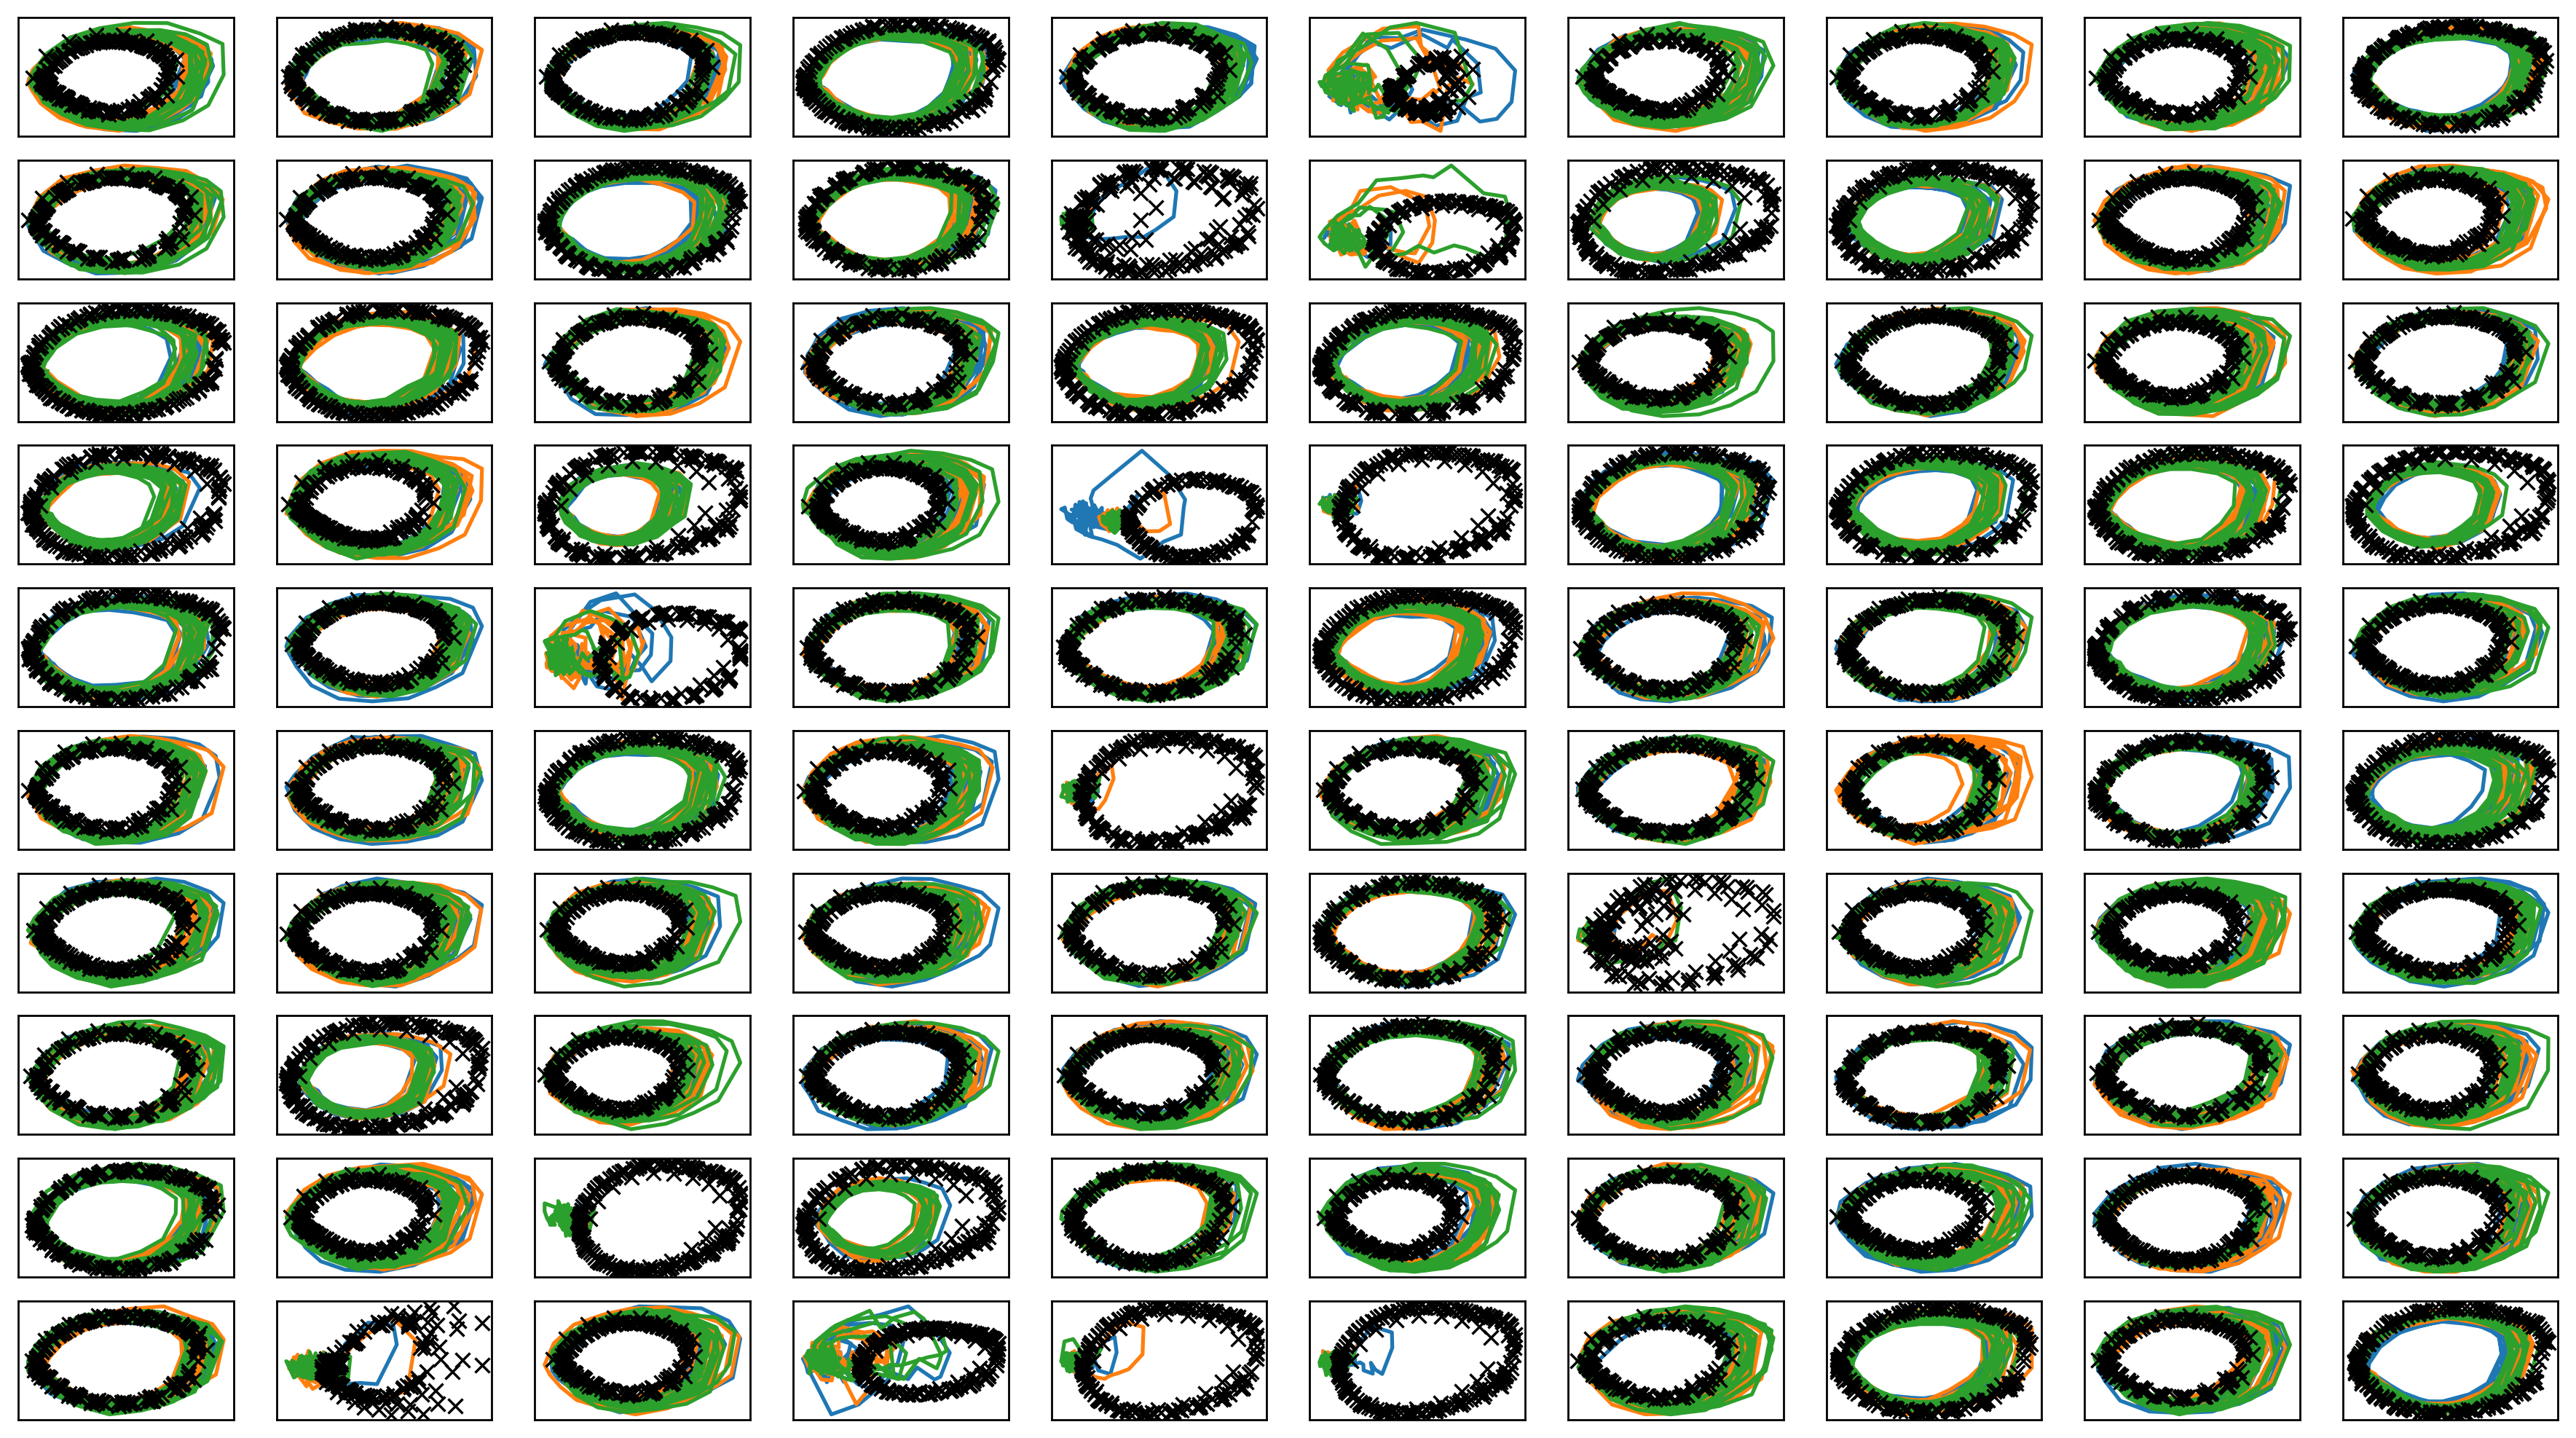

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"iter0.png")
plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [9]:
print(datetime.datetime.now())

2023-03-27 04:20:07.789098


# Iter 1

In [10]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
get_belief:  [ -4.068692 -10.308582] iter 79 len 343 compute_time 0.061 best_loss -1.32e+03 loss.item() -1.32e+03           
 1
get_belief:  [-4.0941486 -8.8203535] iter 52 len 66 compute_time 0.0359 best_loss -243 loss.item() -243           
 2
get_belief:  [ -4.0780783 -10.401443 ] iter 79 len 272 compute_time 0.062 best_loss -1.08e+03 loss.item() -1.08e+03        
 3
get_belief:  [-4.1011686 -8.520227 ] iter 52 len 56 compute_time 0.0361 best_loss -209 loss.item() -208          
 4
get_belief:  [-4.062719 -8.489046] iter 56 len 64 compute_time 0.0386 best_loss -241 loss.item() -241             
 5
get_belief:  [-1.3050141 -6.3201084] iter 122 len 103 compute_time 0.0824 best_loss -2.6 loss.item() -2.48          
 6
get_belief:  [-4.0959253 -9.97886  ] iter 122 len 132 compute_time 0.0841 best_loss -508 loss.item() -507         
 7
get_belief:  [-4.04962  -9.023137] iter 78 len 84 compute_time 0.0542 best_loss -313 loss.item() -313             
 8
get_belief:  [-4.124421 -9.38868

get_belief:  [-4.089083 -8.852538] iter 52 len 75 compute_time 0.0401 best_loss -303 loss.item() -303            
 69
get_belief:  [-4.078683 -9.361777] iter 56 len 126 compute_time 0.044 best_loss -482 loss.item() -481            
 70
get_belief:  [-4.089213 -9.650082] iter 73 len 179 compute_time 0.0527 best_loss -714 loss.item() -710          
 71
get_belief:  [-4.0993333 -9.890555 ] iter 136 len 158 compute_time 0.089 best_loss -602 loss.item() -601         
 72
get_belief:  [-4.0597663 -9.994477 ] iter 368 len 130 compute_time 0.171 best_loss -502 loss.item() -502          
 73
get_belief:  [-4.0601463 -9.553554 ] iter 68 len 104 compute_time 0.0478 best_loss -372 loss.item() -372          
 74
get_belief:  [-4.1001277 -8.428744 ] iter 67 len 53 compute_time 0.0473 best_loss -196 loss.item() -196          
 75
get_belief:  [-4.089443 -9.058167] iter 54 len 111 compute_time 0.0383 best_loss -411 loss.item() -411           
 76
get_belief:  [-4.0808473 -9.568348 ] iter 93 len 152 co

In [11]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)


train: iter 0  trainloss 1.36094  validloss 1.41903±0.00000  bestvalidloss 1.41903  last_update 0
train: iter 1  trainloss 1.21352  validloss 1.31474±0.00000  bestvalidloss 1.31474  last_update 0
train: iter 2  trainloss 1.00225  validloss 1.12151±0.00000  bestvalidloss 1.12151  last_update 0
train: iter 3  trainloss 0.87707  validloss 0.96707±0.00000  bestvalidloss 0.96707  last_update 0
train: iter 4  trainloss 0.79192  validloss 0.88283±0.00000  bestvalidloss 0.88283  last_update 0
train: iter 5  trainloss 0.73677  validloss 0.81835±0.00000  bestvalidloss 0.81835  last_update 0
train: iter 6  trainloss 0.70320  validloss 0.77991±0.00000  bestvalidloss 0.77991  last_update 0
train: iter 7  trainloss 0.68118  validloss 0.75665±0.00000  bestvalidloss 0.75665  last_update 0
train: iter 8  trainloss 0.66226  validloss 0.73816±0.00000  bestvalidloss 0.73816  last_update 0
train: iter 9  trainloss 0.64635  validloss 0.72183±0.00000  bestvalidloss 0.72183  last_update 0
train: iter 10  trai

train: iter 85  trainloss 0.40408  validloss 0.49299±0.00000  bestvalidloss 0.49299  last_update 0
train: iter 86  trainloss 0.40480  validloss 0.50022±0.00000  bestvalidloss 0.49299  last_update 1
train: iter 87  trainloss 0.40424  validloss 0.49733±0.00000  bestvalidloss 0.49299  last_update 2
train: iter 88  trainloss 0.40777  validloss 0.49298±0.00000  bestvalidloss 0.49298  last_update 0
train: iter 89  trainloss 0.40432  validloss 0.50620±0.00000  bestvalidloss 0.49298  last_update 1
train: iter 90  trainloss 0.40224  validloss 0.49720±0.00000  bestvalidloss 0.49298  last_update 2
train: iter 91  trainloss 0.40529  validloss 0.50002±0.00000  bestvalidloss 0.49298  last_update 3
train: iter 92  trainloss 0.40459  validloss 0.50307±0.00000  bestvalidloss 0.49298  last_update 4
train: iter 93  trainloss 0.40057  validloss 0.48800±0.00000  bestvalidloss 0.48800  last_update 0
train: iter 94  trainloss 0.40090  validloss 0.48752±0.00000  bestvalidloss 0.48752  last_update 0
train: ite

train: iter 169  trainloss 0.36199  validloss 0.45543±0.00000  bestvalidloss 0.45543  last_update 0
train: iter 170  trainloss 0.36304  validloss 0.45657±0.00000  bestvalidloss 0.45543  last_update 1
train: iter 171  trainloss 0.36181  validloss 0.46046±0.00000  bestvalidloss 0.45543  last_update 2
train: iter 172  trainloss 0.36157  validloss 0.45547±0.00000  bestvalidloss 0.45543  last_update 3
train: iter 173  trainloss 0.36051  validloss 0.45383±0.00000  bestvalidloss 0.45383  last_update 0
train: iter 174  trainloss 0.36128  validloss 0.45449±0.00000  bestvalidloss 0.45383  last_update 1
train: iter 175  trainloss 0.36183  validloss 0.45437±0.00000  bestvalidloss 0.45383  last_update 2
train: iter 176  trainloss 0.36344  validloss 0.45439±0.00000  bestvalidloss 0.45383  last_update 3
train: iter 177  trainloss 0.35956  validloss 0.45232±0.00000  bestvalidloss 0.45232  last_update 0
train: iter 178  trainloss 0.35865  validloss 0.45363±0.00000  bestvalidloss 0.45232  last_update 1


train: iter 254  trainloss 0.33927  validloss 0.43589±0.00000  bestvalidloss 0.43344  last_update 1
train: iter 255  trainloss 0.34030  validloss 0.43437±0.00000  bestvalidloss 0.43344  last_update 2
train: iter 256  trainloss 0.34056  validloss 0.43227±0.00000  bestvalidloss 0.43227  last_update 0
train: iter 257  trainloss 0.33885  validloss 0.43355±0.00000  bestvalidloss 0.43227  last_update 1
train: iter 258  trainloss 0.33842  validloss 0.43563±0.00000  bestvalidloss 0.43227  last_update 2
train: iter 259  trainloss 0.33811  validloss 0.43344±0.00000  bestvalidloss 0.43227  last_update 3
train: iter 260  trainloss 0.33685  validloss 0.43336±0.00000  bestvalidloss 0.43227  last_update 4
train: iter 261  trainloss 0.34021  validloss 0.43543±0.00000  bestvalidloss 0.43227  last_update 5
train: iter 262  trainloss 0.33706  validloss 0.43626±0.00000  bestvalidloss 0.43227  last_update 6
train: iter 263  trainloss 0.33735  validloss 0.43349±0.00000  bestvalidloss 0.43227  last_update 7


train: iter 338  trainloss 0.33249  validloss 0.44380±0.00000  bestvalidloss 0.42938  last_update 20
train: iter 339  trainloss 0.33322  validloss 0.43061±0.00000  bestvalidloss 0.42938  last_update 21
train: iter 340  trainloss 0.32938  validloss 0.43034±0.00000  bestvalidloss 0.42938  last_update 22
train: iter 341  trainloss 0.33207  validloss 0.43287±0.00000  bestvalidloss 0.42938  last_update 23
train: iter 342  trainloss 0.32956  validloss 0.43137±0.00000  bestvalidloss 0.42938  last_update 24
train: iter 343  trainloss 0.33320  validloss 0.42888±0.00000  bestvalidloss 0.42888  last_update 0
train: iter 344  trainloss 0.33242  validloss 0.46023±0.00000  bestvalidloss 0.42888  last_update 1
train: iter 345  trainloss 0.33004  validloss 0.43113±0.00000  bestvalidloss 0.42888  last_update 2
train: iter 346  trainloss 0.33007  validloss 0.43062±0.00000  bestvalidloss 0.42888  last_update 3
train: iter 347  trainloss 0.33246  validloss 0.43200±0.00000  bestvalidloss 0.42888  last_upda

train: iter 423  trainloss 0.32355  validloss 0.42585±0.00000  bestvalidloss 0.42471  last_update 16
train: iter 424  trainloss 0.32598  validloss 0.42394±0.00000  bestvalidloss 0.42394  last_update 0
train: iter 425  trainloss 0.32273  validloss 0.42407±0.00000  bestvalidloss 0.42394  last_update 1
train: iter 426  trainloss 0.33219  validloss 0.42601±0.00000  bestvalidloss 0.42394  last_update 2
train: iter 427  trainloss 0.32430  validloss 0.42233±0.00000  bestvalidloss 0.42233  last_update 0
train: iter 428  trainloss 0.32307  validloss 0.42300±0.00000  bestvalidloss 0.42233  last_update 1
train: iter 429  trainloss 0.32519  validloss 0.42755±0.00000  bestvalidloss 0.42233  last_update 2
train: iter 430  trainloss 0.32409  validloss 0.42762±0.00000  bestvalidloss 0.42233  last_update 3
train: iter 431  trainloss 0.32337  validloss 0.42236±0.00000  bestvalidloss 0.42233  last_update 4
train: iter 432  trainloss 0.32195  validloss 0.42258±0.00000  bestvalidloss 0.42233  last_update 5

train: iter 508  trainloss 0.29405  validloss 0.40225±0.00000  bestvalidloss 0.40029  last_update 8
train: iter 509  trainloss 0.29498  validloss 0.39743±0.00000  bestvalidloss 0.39743  last_update 0
train: iter 510  trainloss 0.29448  validloss 0.39701±0.00000  bestvalidloss 0.39701  last_update 0
train: iter 511  trainloss 0.29373  validloss 0.39595±0.00000  bestvalidloss 0.39595  last_update 0
train: iter 512  trainloss 0.29682  validloss 0.41425±0.00000  bestvalidloss 0.39595  last_update 1
train: iter 513  trainloss 0.29830  validloss 0.39707±0.00000  bestvalidloss 0.39595  last_update 2
train: iter 514  trainloss 0.29410  validloss 0.39749±0.00000  bestvalidloss 0.39595  last_update 3
train: iter 515  trainloss 0.29004  validloss 0.40414±0.00000  bestvalidloss 0.39595  last_update 4
train: iter 516  trainloss 0.29115  validloss 0.39320±0.00000  bestvalidloss 0.39320  last_update 0
train: iter 517  trainloss 0.29075  validloss 0.39306±0.00000  bestvalidloss 0.39306  last_update 0


train: iter 592  trainloss 0.25953  validloss 0.36374±0.00000  bestvalidloss 0.36374  last_update 0
train: iter 593  trainloss 0.25889  validloss 0.36605±0.00000  bestvalidloss 0.36374  last_update 1
train: iter 594  trainloss 0.26128  validloss 0.36554±0.00000  bestvalidloss 0.36374  last_update 2
train: iter 595  trainloss 0.25871  validloss 0.36306±0.00000  bestvalidloss 0.36306  last_update 0
train: iter 596  trainloss 0.26059  validloss 0.36324±0.00000  bestvalidloss 0.36306  last_update 1
train: iter 597  trainloss 0.25795  validloss 0.36398±0.00000  bestvalidloss 0.36306  last_update 2
train: iter 598  trainloss 0.25851  validloss 0.36602±0.00000  bestvalidloss 0.36306  last_update 3
train: iter 599  trainloss 0.25847  validloss 0.36204±0.00000  bestvalidloss 0.36204  last_update 0
train: iter 600  trainloss 0.25800  validloss 0.36243±0.00000  bestvalidloss 0.36204  last_update 1
train: iter 601  trainloss 0.25733  validloss 0.36404±0.00000  bestvalidloss 0.36204  last_update 2


train: iter 676  trainloss 0.24410  validloss 0.34661±0.00000  bestvalidloss 0.34605  last_update 1
train: iter 677  trainloss 0.24024  validloss 0.34737±0.00000  bestvalidloss 0.34605  last_update 2
train: iter 678  trainloss 0.24045  validloss 0.35277±0.00000  bestvalidloss 0.34605  last_update 3
train: iter 679  trainloss 0.24158  validloss 0.34455±0.00000  bestvalidloss 0.34455  last_update 0
train: iter 680  trainloss 0.23943  validloss 0.34595±0.00000  bestvalidloss 0.34455  last_update 1
train: iter 681  trainloss 0.23947  validloss 0.34578±0.00000  bestvalidloss 0.34455  last_update 2
train: iter 682  trainloss 0.23966  validloss 0.35104±0.00000  bestvalidloss 0.34455  last_update 3
train: iter 683  trainloss 0.23754  validloss 0.34551±0.00000  bestvalidloss 0.34455  last_update 4
train: iter 684  trainloss 0.24018  validloss 0.34555±0.00000  bestvalidloss 0.34455  last_update 5
train: iter 685  trainloss 0.23795  validloss 0.34898±0.00000  bestvalidloss 0.34455  last_update 6


train: iter 761  trainloss 0.22509  validloss 0.32946±0.00000  bestvalidloss 0.32946  last_update 0
train: iter 762  trainloss 0.22407  validloss 0.33149±0.00000  bestvalidloss 0.32946  last_update 1
train: iter 763  trainloss 0.22326  validloss 0.33006±0.00000  bestvalidloss 0.32946  last_update 2
train: iter 764  trainloss 0.22496  validloss 0.32837±0.00000  bestvalidloss 0.32837  last_update 0
train: iter 765  trainloss 0.22302  validloss 0.32660±0.00000  bestvalidloss 0.32660  last_update 0
train: iter 766  trainloss 0.22328  validloss 0.33048±0.00000  bestvalidloss 0.32660  last_update 1
train: iter 767  trainloss 0.22429  validloss 0.33162±0.00000  bestvalidloss 0.32660  last_update 2
train: iter 768  trainloss 0.22521  validloss 0.33094±0.00000  bestvalidloss 0.32660  last_update 3
train: iter 769  trainloss 0.22473  validloss 0.32973±0.00000  bestvalidloss 0.32660  last_update 4
train: iter 770  trainloss 0.22385  validloss 0.32813±0.00000  bestvalidloss 0.32660  last_update 5


train: iter 846  trainloss 0.20705  validloss 0.29732±0.00000  bestvalidloss 0.29625  last_update 2
train: iter 847  trainloss 0.20400  validloss 0.29815±0.00000  bestvalidloss 0.29625  last_update 3
train: iter 848  trainloss 0.20409  validloss 0.30054±0.00000  bestvalidloss 0.29625  last_update 4
train: iter 849  trainloss 0.20395  validloss 0.30034±0.00000  bestvalidloss 0.29625  last_update 5
train: iter 850  trainloss 0.20494  validloss 0.30049±0.00000  bestvalidloss 0.29625  last_update 6
train: iter 851  trainloss 0.20566  validloss 0.29440±0.00000  bestvalidloss 0.29440  last_update 0
train: iter 852  trainloss 0.20540  validloss 0.29593±0.00000  bestvalidloss 0.29440  last_update 1
train: iter 853  trainloss 0.20300  validloss 0.29464±0.00000  bestvalidloss 0.29440  last_update 2
train: iter 854  trainloss 0.20438  validloss 0.29911±0.00000  bestvalidloss 0.29440  last_update 3
train: iter 855  trainloss 0.20478  validloss 0.29385±0.00000  bestvalidloss 0.29385  last_update 0


train: iter 930  trainloss 0.18470  validloss 0.27085±0.00000  bestvalidloss 0.26733  last_update 11
train: iter 931  trainloss 0.18615  validloss 0.26825±0.00000  bestvalidloss 0.26733  last_update 12
train: iter 932  trainloss 0.18515  validloss 0.26464±0.00000  bestvalidloss 0.26464  last_update 0
train: iter 933  trainloss 0.18804  validloss 0.26986±0.00000  bestvalidloss 0.26464  last_update 1
train: iter 934  trainloss 0.18461  validloss 0.26937±0.00000  bestvalidloss 0.26464  last_update 2
train: iter 935  trainloss 0.18470  validloss 0.27170±0.00000  bestvalidloss 0.26464  last_update 3
train: iter 936  trainloss 0.18657  validloss 0.26819±0.00000  bestvalidloss 0.26464  last_update 4
train: iter 937  trainloss 0.18263  validloss 0.26472±0.00000  bestvalidloss 0.26464  last_update 5
train: iter 938  trainloss 0.18447  validloss 0.26890±0.00000  bestvalidloss 0.26464  last_update 6
train: iter 939  trainloss 0.18477  validloss 0.26180±0.00000  bestvalidloss 0.26180  last_update 

train: iter 1015  trainloss 0.15648  validloss 0.24760±0.00000  bestvalidloss 0.24066  last_update 14
train: iter 1016  trainloss 0.15444  validloss 0.24120±0.00000  bestvalidloss 0.24066  last_update 15
train: iter 1017  trainloss 0.15367  validloss 0.24930±0.00000  bestvalidloss 0.24066  last_update 16
train: iter 1018  trainloss 0.15311  validloss 0.24099±0.00000  bestvalidloss 0.24066  last_update 17
train: iter 1019  trainloss 0.15710  validloss 0.25067±0.00000  bestvalidloss 0.24066  last_update 18
train: iter 1020  trainloss 0.15229  validloss 0.25077±0.00000  bestvalidloss 0.24066  last_update 19
train: iter 1021  trainloss 0.15356  validloss 0.24470±0.00000  bestvalidloss 0.24066  last_update 20
train: iter 1022  trainloss 0.15187  validloss 0.24274±0.00000  bestvalidloss 0.24066  last_update 21
train: iter 1023  trainloss 0.15196  validloss 0.24283±0.00000  bestvalidloss 0.24066  last_update 22
train: iter 1024  trainloss 0.15146  validloss 0.24161±0.00000  bestvalidloss 0.24

train: iter 1100  trainloss 0.14363  validloss 0.23757±0.00000  bestvalidloss 0.22698  last_update 3
train: iter 1101  trainloss 0.14589  validloss 0.23263±0.00000  bestvalidloss 0.22698  last_update 4
train: iter 1102  trainloss 0.14399  validloss 0.22537±0.00000  bestvalidloss 0.22537  last_update 0
train: iter 1103  trainloss 0.14332  validloss 0.23415±0.00000  bestvalidloss 0.22537  last_update 1
train: iter 1104  trainloss 0.14467  validloss 0.22814±0.00000  bestvalidloss 0.22537  last_update 2
train: iter 1105  trainloss 0.14283  validloss 0.22562±0.00000  bestvalidloss 0.22537  last_update 3
train: iter 1106  trainloss 0.14652  validloss 0.23122±0.00000  bestvalidloss 0.22537  last_update 4
train: iter 1107  trainloss 0.14456  validloss 0.22786±0.00000  bestvalidloss 0.22537  last_update 5
train: iter 1108  trainloss 0.14311  validloss 0.22336±0.00000  bestvalidloss 0.22336  last_update 0
train: iter 1109  trainloss 0.14268  validloss 0.22753±0.00000  bestvalidloss 0.22336  last

train: iter 1185  trainloss 0.14213  validloss 0.22211±0.00000  bestvalidloss 0.21808  last_update 17
train: iter 1186  trainloss 0.13767  validloss 0.21441±0.00000  bestvalidloss 0.21441  last_update 0
train: iter 1187  trainloss 0.14027  validloss 0.21842±0.00000  bestvalidloss 0.21441  last_update 1
train: iter 1188  trainloss 0.14056  validloss 0.22545±0.00000  bestvalidloss 0.21441  last_update 2
train: iter 1189  trainloss 0.13878  validloss 0.22323±0.00000  bestvalidloss 0.21441  last_update 3
train: iter 1190  trainloss 0.13801  validloss 0.22073±0.00000  bestvalidloss 0.21441  last_update 4
train: iter 1191  trainloss 0.13906  validloss 0.22819±0.00000  bestvalidloss 0.21441  last_update 5
train: iter 1192  trainloss 0.13910  validloss 0.22245±0.00000  bestvalidloss 0.21441  last_update 6
train: iter 1193  trainloss 0.13755  validloss 0.22097±0.00000  bestvalidloss 0.21441  last_update 7
train: iter 1194  trainloss 0.13752  validloss 0.22252±0.00000  bestvalidloss 0.21441  las

train: iter 1270  trainloss 0.13566  validloss 0.22725±0.00000  bestvalidloss 0.21375  last_update 5
train: iter 1271  trainloss 0.13334  validloss 0.22681±0.00000  bestvalidloss 0.21375  last_update 6
train: iter 1272  trainloss 0.13453  validloss 0.21354±0.00000  bestvalidloss 0.21354  last_update 0
train: iter 1273  trainloss 0.13340  validloss 0.21712±0.00000  bestvalidloss 0.21354  last_update 1
train: iter 1274  trainloss 0.13366  validloss 0.21421±0.00000  bestvalidloss 0.21354  last_update 2
train: iter 1275  trainloss 0.13776  validloss 0.21527±0.00000  bestvalidloss 0.21354  last_update 3
train: iter 1276  trainloss 0.13660  validloss 0.22230±0.00000  bestvalidloss 0.21354  last_update 4
train: iter 1277  trainloss 0.13260  validloss 0.21494±0.00000  bestvalidloss 0.21354  last_update 5
train: iter 1278  trainloss 0.13426  validloss 0.21403±0.00000  bestvalidloss 0.21354  last_update 6
train: iter 1279  trainloss 0.13529  validloss 0.22035±0.00000  bestvalidloss 0.21354  last

train: iter 1354  trainloss 0.13043  validloss 0.21734±0.00000  bestvalidloss 0.20857  last_update 25
train: iter 1355  trainloss 0.13033  validloss 0.21407±0.00000  bestvalidloss 0.20857  last_update 26
train: iter 1356  trainloss 0.13251  validloss 0.21574±0.00000  bestvalidloss 0.20857  last_update 27
train: iter 1357  trainloss 0.12815  validloss 0.21317±0.00000  bestvalidloss 0.20857  last_update 28
train: iter 1358  trainloss 0.12922  validloss 0.21133±0.00000  bestvalidloss 0.20857  last_update 29
train: iter 1359  trainloss 0.12874  validloss 0.21287±0.00000  bestvalidloss 0.20857  last_update 30
train: iter 1360  trainloss 0.13015  validloss 0.21315±0.00000  bestvalidloss 0.20857  last_update 31
train: iter 1361  trainloss 0.12764  validloss 0.22063±0.00000  bestvalidloss 0.20857  last_update 32
train: iter 1362  trainloss 0.13203  validloss 0.24717±0.00000  bestvalidloss 0.20857  last_update 33
train: iter 1363  trainloss 0.12918  validloss 0.21703±0.00000  bestvalidloss 0.20

train: iter 1439  trainloss 0.12578  validloss 0.21319±0.00000  bestvalidloss 0.20592  last_update 14
train: iter 1440  trainloss 0.12622  validloss 0.21726±0.00000  bestvalidloss 0.20592  last_update 15
train: iter 1441  trainloss 0.12805  validloss 0.21586±0.00000  bestvalidloss 0.20592  last_update 16
train: iter 1442  trainloss 0.12549  validloss 0.21118±0.00000  bestvalidloss 0.20592  last_update 17
train: iter 1443  trainloss 0.13058  validloss 0.21139±0.00000  bestvalidloss 0.20592  last_update 18
train: iter 1444  trainloss 0.12563  validloss 0.21045±0.00000  bestvalidloss 0.20592  last_update 19
train: iter 1445  trainloss 0.12731  validloss 0.21494±0.00000  bestvalidloss 0.20592  last_update 20
train: iter 1446  trainloss 0.12994  validloss 0.21449±0.00000  bestvalidloss 0.20592  last_update 21
train: iter 1447  trainloss 0.12882  validloss 0.21444±0.00000  bestvalidloss 0.20592  last_update 22
train: iter 1448  trainloss 0.12657  validloss 0.21461±0.00000  bestvalidloss 0.20

train: iter 1522  trainloss 0.12495  validloss 0.20999±0.00000  bestvalidloss 0.20534  last_update 35
train: iter 1523  trainloss 0.12333  validloss 0.20692±0.00000  bestvalidloss 0.20534  last_update 36
train: iter 1524  trainloss 0.12897  validloss 0.21016±0.00000  bestvalidloss 0.20534  last_update 37
train: iter 1525  trainloss 0.12614  validloss 0.20580±0.00000  bestvalidloss 0.20534  last_update 38
train: iter 1526  trainloss 0.12590  validloss 0.21636±0.00000  bestvalidloss 0.20534  last_update 39
train: iter 1527  trainloss 0.12330  validloss 0.21940±0.00000  bestvalidloss 0.20534  last_update 40
train: iter 1528  trainloss 0.12383  validloss 0.21477±0.00000  bestvalidloss 0.20534  last_update 41
train: iter 1529  trainloss 0.12599  validloss 0.21192±0.00000  bestvalidloss 0.20534  last_update 42
train: iter 1530  trainloss 0.12508  validloss 0.21353±0.00000  bestvalidloss 0.20534  last_update 43
train: iter 1531  trainloss 0.12369  validloss 0.21370±0.00000  bestvalidloss 0.20

train: iter 1607  trainloss 0.12258  validloss 0.20313±0.00000  bestvalidloss 0.20313  last_update 0
train: iter 1608  trainloss 0.12345  validloss 0.20618±0.00000  bestvalidloss 0.20313  last_update 1
train: iter 1609  trainloss 0.12325  validloss 0.20700±0.00000  bestvalidloss 0.20313  last_update 2
train: iter 1610  trainloss 0.12278  validloss 0.20648±0.00000  bestvalidloss 0.20313  last_update 3
train: iter 1611  trainloss 0.12514  validloss 0.20320±0.00000  bestvalidloss 0.20313  last_update 4
train: iter 1612  trainloss 0.12223  validloss 0.20453±0.00000  bestvalidloss 0.20313  last_update 5
train: iter 1613  trainloss 0.12405  validloss 0.20936±0.00000  bestvalidloss 0.20313  last_update 6
train: iter 1614  trainloss 0.12266  validloss 0.20517±0.00000  bestvalidloss 0.20313  last_update 7
train: iter 1615  trainloss 0.12414  validloss 0.21292±0.00000  bestvalidloss 0.20313  last_update 8
train: iter 1616  trainloss 0.12153  validloss 0.20897±0.00000  bestvalidloss 0.20313  last

train: iter 1691  trainloss 0.11995  validloss 0.20751±0.00000  bestvalidloss 0.19841  last_update 2
train: iter 1692  trainloss 0.12521  validloss 0.20944±0.00000  bestvalidloss 0.19841  last_update 3
train: iter 1693  trainloss 0.12022  validloss 0.20363±0.00000  bestvalidloss 0.19841  last_update 4
train: iter 1694  trainloss 0.12211  validloss 0.20745±0.00000  bestvalidloss 0.19841  last_update 5
train: iter 1695  trainloss 0.12043  validloss 0.20417±0.00000  bestvalidloss 0.19841  last_update 6
train: iter 1696  trainloss 0.12218  validloss 0.20329±0.00000  bestvalidloss 0.19841  last_update 7
train: iter 1697  trainloss 0.12119  validloss 0.20702±0.00000  bestvalidloss 0.19841  last_update 8
train: iter 1698  trainloss 0.12250  validloss 0.20594±0.00000  bestvalidloss 0.19841  last_update 9
train: iter 1699  trainloss 0.12182  validloss 0.20399±0.00000  bestvalidloss 0.19841  last_update 10
train: iter 1700  trainloss 0.12114  validloss 0.21013±0.00000  bestvalidloss 0.19841  las

train: iter 1776  trainloss 0.11724  validloss 0.19925±0.00000  bestvalidloss 0.19796  last_update 5
train: iter 1777  trainloss 0.11765  validloss 0.20647±0.00000  bestvalidloss 0.19796  last_update 6
train: iter 1778  trainloss 0.11908  validloss 0.20677±0.00000  bestvalidloss 0.19796  last_update 7
train: iter 1779  trainloss 0.11923  validloss 0.21200±0.00000  bestvalidloss 0.19796  last_update 8
train: iter 1780  trainloss 0.11859  validloss 0.20394±0.00000  bestvalidloss 0.19796  last_update 9
train: iter 1781  trainloss 0.12166  validloss 0.21455±0.00000  bestvalidloss 0.19796  last_update 10
train: iter 1782  trainloss 0.11989  validloss 0.20812±0.00000  bestvalidloss 0.19796  last_update 11
train: iter 1783  trainloss 0.11859  validloss 0.22602±0.00000  bestvalidloss 0.19796  last_update 12
train: iter 1784  trainloss 0.11886  validloss 0.21993±0.00000  bestvalidloss 0.19796  last_update 13
train: iter 1785  trainloss 0.12027  validloss 0.20285±0.00000  bestvalidloss 0.19796  

train: iter 1861  trainloss 0.11667  validloss 0.20366±0.00000  bestvalidloss 0.19637  last_update 36
train: iter 1862  trainloss 0.11763  validloss 0.19753±0.00000  bestvalidloss 0.19637  last_update 37
train: iter 1863  trainloss 0.11825  validloss 0.20233±0.00000  bestvalidloss 0.19637  last_update 38
train: iter 1864  trainloss 0.11948  validloss 0.20383±0.00000  bestvalidloss 0.19637  last_update 39
train: iter 1865  trainloss 0.11886  validloss 0.21276±0.00000  bestvalidloss 0.19637  last_update 40
train: iter 1866  trainloss 0.11760  validloss 0.20602±0.00000  bestvalidloss 0.19637  last_update 41
train: iter 1867  trainloss 0.11785  validloss 0.20279±0.00000  bestvalidloss 0.19637  last_update 42
train: iter 1868  trainloss 0.11667  validloss 0.21486±0.00000  bestvalidloss 0.19637  last_update 43
train: iter 1869  trainloss 0.12015  validloss 0.20485±0.00000  bestvalidloss 0.19637  last_update 44
train: iter 1870  trainloss 0.11688  validloss 0.20777±0.00000  bestvalidloss 0.19

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -266.47847193032504
valid_loss:  -368.9637736749649
train_loss:  -75.52061870723963
valid_loss:  -79.81977191925048


1e-08 1000.0


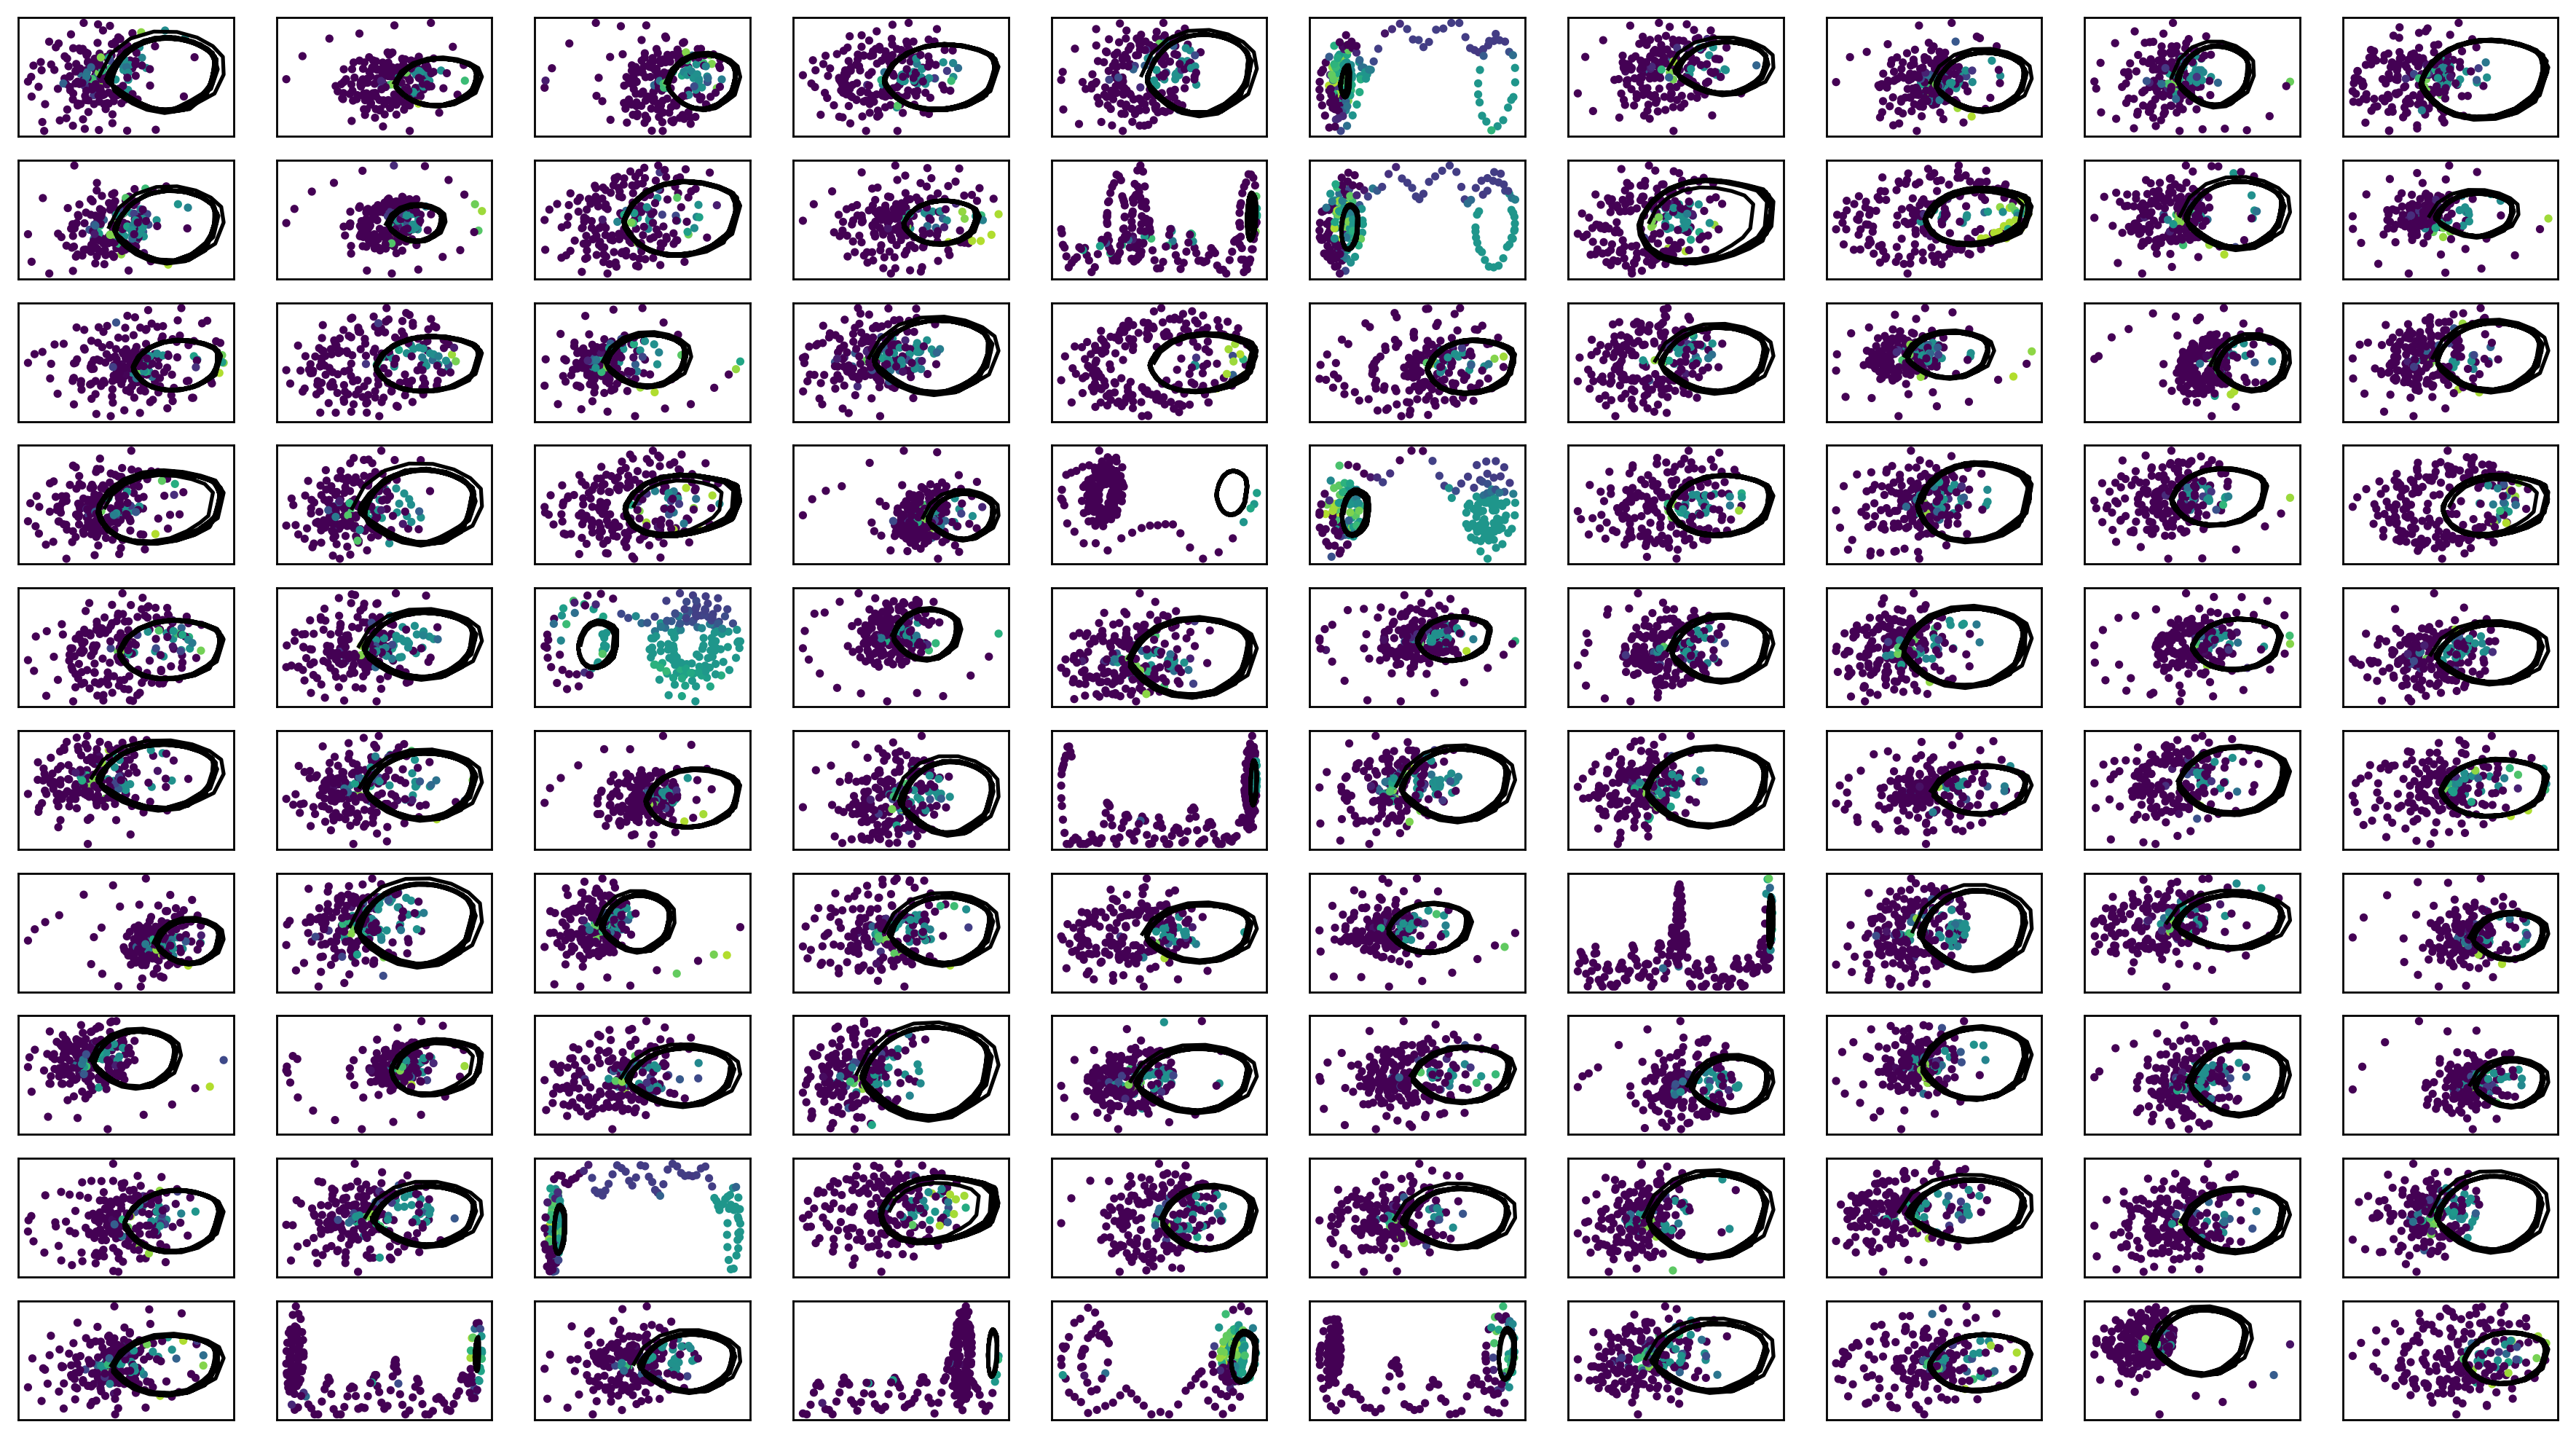

In [13]:

def f(x):
#     return x
    return np.log10(x)

fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter1.png")

In [14]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
# #     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [15]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
# #     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [16]:
# for i in range(100):
#     print(i, " ", end="")
#     fig = plt.figure(figsize=(16,10), dpi=150)
#     fig.patch.set_facecolor('white')
#     plt.plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     plt.plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     plt.scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()),
#                vmin=-8, vmax=3
#                )
#     plt.colorbar()
#     plt.savefig("ratio"+str(i)+".png")
#     plt.close()

train_weighted_vae: enc_dec
train: iter 0  trainloss -71.42685  validloss -79.73764±0.00000  bestvalidloss -79.73764  last_update 0
train: iter 1  trainloss -67.37570  validloss -80.13386±0.00000  bestvalidloss -80.13386  last_update 0
train: iter 2  trainloss -78.94442  validloss -78.59560±0.00000  bestvalidloss -80.13386  last_update 1
train: iter 3  trainloss -78.65845  validloss -83.15610±0.00000  bestvalidloss -83.15610  last_update 0
train: iter 4  trainloss -77.92542  validloss -85.35615±0.00000  bestvalidloss -85.35615  last_update 0
train: iter 5  trainloss -80.25479  validloss -66.61281±0.00000  bestvalidloss -85.35615  last_update 1
train: iter 6  trainloss -86.15346  validloss -86.91551±0.00000  bestvalidloss -86.91551  last_update 0
train: iter 7  trainloss -87.38077  validloss -80.68112±0.00000  bestvalidloss -86.91551  last_update 1
train: iter 8  trainloss -86.70541  validloss -89.04569±0.00000  bestvalidloss -89.04569  last_update 0
train: iter 9  trainloss -84.23698  

train: iter 77  trainloss -163.91096  validloss -171.54998±0.00000  bestvalidloss -171.54998  last_update 0
train: iter 78  trainloss -160.52149  validloss -165.54790±0.00000  bestvalidloss -171.54998  last_update 1
train: iter 79  trainloss -164.43021  validloss -173.14628±0.00000  bestvalidloss -173.14628  last_update 0
train: iter 80  trainloss -159.89038  validloss -169.45120±0.00000  bestvalidloss -173.14628  last_update 1
train: iter 81  trainloss -165.39387  validloss -173.50880±0.00000  bestvalidloss -173.50880  last_update 0
train: iter 82  trainloss -168.24986  validloss -166.56000±0.00000  bestvalidloss -173.50880  last_update 1
train: iter 83  trainloss -172.52686  validloss -180.76766±0.00000  bestvalidloss -180.76766  last_update 0
train: iter 84  trainloss -169.84400  validloss -165.24144±0.00000  bestvalidloss -180.76766  last_update 1
train: iter 85  trainloss -172.04785  validloss -177.46489±0.00000  bestvalidloss -180.76766  last_update 2
train: iter 86  trainloss -1

train: iter 153  trainloss -299.98818  validloss -283.87470±0.00000  bestvalidloss -304.31456  last_update 2
train: iter 154  trainloss -302.35466  validloss -289.91409±0.00000  bestvalidloss -304.31456  last_update 3
train: iter 155  trainloss -300.60757  validloss -278.81946±0.00000  bestvalidloss -304.31456  last_update 4
train: iter 156  trainloss -308.78911  validloss -292.15051±0.00000  bestvalidloss -304.31456  last_update 5
train: iter 157  trainloss -314.51878  validloss -319.36493±0.00000  bestvalidloss -319.36493  last_update 0
train: iter 158  trainloss -316.42404  validloss -302.81339±0.00000  bestvalidloss -319.36493  last_update 1
train: iter 159  trainloss -318.55959  validloss -310.47115±0.00000  bestvalidloss -319.36493  last_update 2
train: iter 160  trainloss -321.21583  validloss -309.30861±0.00000  bestvalidloss -319.36493  last_update 3
train: iter 161  trainloss -323.33045  validloss -326.15592±0.00000  bestvalidloss -326.15592  last_update 0
train: iter 162  tr

train: iter 229  trainloss -531.74300  validloss -507.84071±0.00000  bestvalidloss -518.52391  last_update 1
train: iter 230  trainloss -532.39040  validloss -478.36647±0.00000  bestvalidloss -518.52391  last_update 2
train: iter 231  trainloss -535.92695  validloss -488.38691±0.00000  bestvalidloss -518.52391  last_update 3
train: iter 232  trainloss -537.00973  validloss -513.36985±0.00000  bestvalidloss -518.52391  last_update 4
train: iter 233  trainloss -539.95867  validloss -472.57399±0.00000  bestvalidloss -518.52391  last_update 5
train: iter 234  trainloss -547.44009  validloss -524.67843±0.00000  bestvalidloss -524.67843  last_update 0
train: iter 235  trainloss -544.97484  validloss -482.89344±0.00000  bestvalidloss -524.67843  last_update 1
train: iter 236  trainloss -542.29969  validloss -473.61181±0.00000  bestvalidloss -524.67843  last_update 2
train: iter 237  trainloss -542.43665  validloss -518.78552±0.00000  bestvalidloss -524.67843  last_update 3
train: iter 238  tr

train: iter 305  trainloss -639.70800  validloss -574.57755±0.00000  bestvalidloss -617.52321  last_update 3
train: iter 306  trainloss -634.93752  validloss -554.81398±0.00000  bestvalidloss -617.52321  last_update 4
train: iter 307  trainloss -636.66841  validloss -579.10737±0.00000  bestvalidloss -617.52321  last_update 5
train: iter 308  trainloss -644.44665  validloss -598.52743±0.00000  bestvalidloss -617.52321  last_update 6
train: iter 309  trainloss -644.04177  validloss -594.12972±0.00000  bestvalidloss -617.52321  last_update 7
train: iter 310  trainloss -640.60105  validloss -618.03864±0.00000  bestvalidloss -618.03864  last_update 0
train: iter 311  trainloss -650.23874  validloss -602.22420±0.00000  bestvalidloss -618.03864  last_update 1
train: iter 312  trainloss -648.22721  validloss -569.00770±0.00000  bestvalidloss -618.03864  last_update 2
train: iter 313  trainloss -640.31538  validloss -598.89026±0.00000  bestvalidloss -618.03864  last_update 3
train: iter 314  tr

train: iter 381  trainloss -784.60748  validloss -742.02973±0.00000  bestvalidloss -742.02973  last_update 0
train: iter 382  trainloss -783.15248  validloss -731.56628±0.00000  bestvalidloss -742.02973  last_update 1
train: iter 383  trainloss -763.01106  validloss -703.55886±0.00000  bestvalidloss -742.02973  last_update 2
train: iter 384  trainloss -791.13119  validloss -737.80786±0.00000  bestvalidloss -742.02973  last_update 3
train: iter 385  trainloss -784.84182  validloss -739.55524±0.00000  bestvalidloss -742.02973  last_update 4
train: iter 386  trainloss -790.23973  validloss -722.69537±0.00000  bestvalidloss -742.02973  last_update 5
train: iter 387  trainloss -792.33984  validloss -711.54382±0.00000  bestvalidloss -742.02973  last_update 6
train: iter 388  trainloss -764.88002  validloss -709.48989±0.00000  bestvalidloss -742.02973  last_update 7
train: iter 389  trainloss -796.36906  validloss -669.12061±0.00000  bestvalidloss -742.02973  last_update 8
train: iter 390  tr

train: iter 457  trainloss -821.38669  validloss -622.05713±0.00000  bestvalidloss -774.89187  last_update 10
train: iter 458  trainloss -762.46939  validloss -743.71273±0.00000  bestvalidloss -774.89187  last_update 11
train: iter 459  trainloss -820.17288  validloss -723.12768±0.00000  bestvalidloss -774.89187  last_update 12
train: iter 460  trainloss -828.54625  validloss -725.24977±0.00000  bestvalidloss -774.89187  last_update 13
train: iter 461  trainloss -833.84082  validloss -761.84173±0.00000  bestvalidloss -774.89187  last_update 14
train: iter 462  trainloss -810.57508  validloss -659.22427±0.00000  bestvalidloss -774.89187  last_update 15
train: iter 463  trainloss -820.38624  validloss -772.41582±0.00000  bestvalidloss -774.89187  last_update 16
train: iter 464  trainloss -815.99455  validloss -734.29532±0.00000  bestvalidloss -774.89187  last_update 17
train: iter 465  trainloss -825.60195  validloss -762.38730±0.00000  bestvalidloss -774.89187  last_update 18
train: ite

train: iter 532  trainloss -829.78965  validloss -770.88639±0.00000  bestvalidloss -789.32379  last_update 36
train: iter 533  trainloss -832.29642  validloss -770.20453±0.00000  bestvalidloss -789.32379  last_update 37
train: iter 534  trainloss -808.11068  validloss -742.37056±0.00000  bestvalidloss -789.32379  last_update 38
train: iter 535  trainloss -824.99198  validloss -686.78207±0.00000  bestvalidloss -789.32379  last_update 39
train: iter 536  trainloss -825.69780  validloss -776.32786±0.00000  bestvalidloss -789.32379  last_update 40
train: iter 537  trainloss -814.44876  validloss -759.06409±0.00000  bestvalidloss -789.32379  last_update 41
train: iter 538  trainloss -803.60464  validloss -735.39688±0.00000  bestvalidloss -789.32379  last_update 42
train: iter 539  trainloss -816.50772  validloss -745.78892±0.00000  bestvalidloss -789.32379  last_update 43
train: iter 540  trainloss -816.12288  validloss -758.31503±0.00000  bestvalidloss -789.32379  last_update 44
train: ite

train: iter 607  trainloss -821.25865  validloss -704.03990±0.00000  bestvalidloss -791.62009  last_update 21
train: iter 608  trainloss -793.32640  validloss -689.63052±0.00000  bestvalidloss -791.62009  last_update 22
train: iter 609  trainloss -807.89586  validloss -747.71517±0.00000  bestvalidloss -791.62009  last_update 23
train: iter 610  trainloss -839.77897  validloss -761.30429±0.00000  bestvalidloss -791.62009  last_update 24
train: iter 611  trainloss -826.50292  validloss -712.67708±0.00000  bestvalidloss -791.62009  last_update 25
train: iter 612  trainloss -819.55858  validloss -734.46470±0.00000  bestvalidloss -791.62009  last_update 26
train: iter 613  trainloss -818.16014  validloss -737.93562±0.00000  bestvalidloss -791.62009  last_update 27
train: iter 614  trainloss -828.09791  validloss -710.80161±0.00000  bestvalidloss -791.62009  last_update 28
train: iter 615  trainloss -828.25518  validloss -720.24860±0.00000  bestvalidloss -791.62009  last_update 29
train: ite

train: iter 682  trainloss -814.79093  validloss -681.39328±0.00000  bestvalidloss -791.62009  last_update 96
train: iter 683  trainloss -839.88540  validloss -774.92886±0.00000  bestvalidloss -791.62009  last_update 97
train: iter 684  trainloss -837.96786  validloss -759.62055±0.00000  bestvalidloss -791.62009  last_update 98
train: iter 685  trainloss -832.11605  validloss -729.11495±0.00000  bestvalidloss -791.62009  last_update 99
train: iter 686  trainloss -833.55232  validloss -716.61418±0.00000  bestvalidloss -791.62009  last_update 100
train: fin


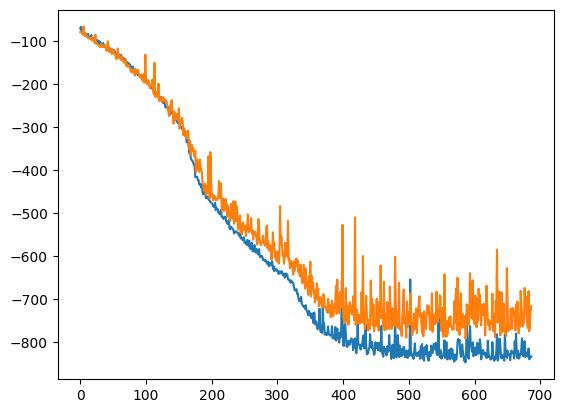

train_weighted_vae: enc
train: iter 0  trainloss -805.68273  validloss -706.66174±0.00000  bestvalidloss -706.66174  last_update 0
train: iter 1  trainloss -830.49375  validloss -749.55653±0.00000  bestvalidloss -749.55653  last_update 0
train: iter 2  trainloss -824.38868  validloss -747.55048±0.00000  bestvalidloss -749.55653  last_update 1
train: iter 3  trainloss -826.99738  validloss -696.96170±0.00000  bestvalidloss -749.55653  last_update 2
train: iter 4  trainloss -814.93807  validloss -719.89267±0.00000  bestvalidloss -749.55653  last_update 3
train: iter 5  trainloss -819.96809  validloss -734.77061±0.00000  bestvalidloss -749.55653  last_update 4
train: iter 6  trainloss -817.39638  validloss -732.34852±0.00000  bestvalidloss -749.55653  last_update 5
train: iter 7  trainloss -823.51258  validloss -649.49745±0.00000  bestvalidloss -749.55653  last_update 6
train: iter 8  trainloss -822.99410  validloss -648.47831±0.00000  bestvalidloss -749.55653  last_update 7
train: iter 9

train: iter 78  trainloss -832.64557  validloss -715.19621±0.00000  bestvalidloss -778.17808  last_update 32
train: iter 79  trainloss -826.37252  validloss -776.56036±0.00000  bestvalidloss -778.17808  last_update 33
train: iter 80  trainloss -828.51128  validloss -705.96808±0.00000  bestvalidloss -778.17808  last_update 34
train: iter 81  trainloss -830.53932  validloss -757.86697±0.00000  bestvalidloss -778.17808  last_update 35
train: iter 82  trainloss -823.57997  validloss -734.17010±0.00000  bestvalidloss -778.17808  last_update 36
train: iter 83  trainloss -820.12247  validloss -698.39917±0.00000  bestvalidloss -778.17808  last_update 37
train: iter 84  trainloss -828.89268  validloss -739.30561±0.00000  bestvalidloss -778.17808  last_update 38
train: iter 85  trainloss -826.44657  validloss -744.14014±0.00000  bestvalidloss -778.17808  last_update 39
train: iter 86  trainloss -823.30448  validloss -730.77157±0.00000  bestvalidloss -778.17808  last_update 40
train: iter 87  tra

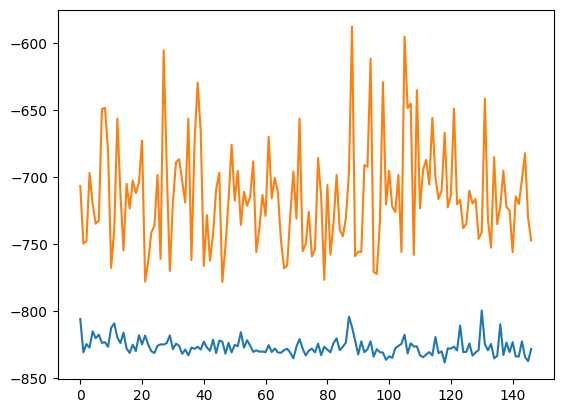

train_weighted_vae: dec
train: iter 0  trainloss -851.76122  validloss -750.06842±0.00000  bestvalidloss -750.06842  last_update 0
train: iter 1  trainloss -849.43238  validloss -713.05436±0.00000  bestvalidloss -750.06842  last_update 1
train: iter 2  trainloss -860.85937  validloss -739.29812±0.00000  bestvalidloss -750.06842  last_update 2
train: iter 3  trainloss -854.14743  validloss -741.85045±0.00000  bestvalidloss -750.06842  last_update 3
train: iter 4  trainloss -840.15868  validloss -676.11931±0.00000  bestvalidloss -750.06842  last_update 4
train: iter 5  trainloss -862.47971  validloss -748.19583±0.00000  bestvalidloss -750.06842  last_update 5
train: iter 6  trainloss -840.58110  validloss -727.25238±0.00000  bestvalidloss -750.06842  last_update 6
train: iter 7  trainloss -857.43713  validloss -761.30351±0.00000  bestvalidloss -761.30351  last_update 0
train: iter 8  trainloss -852.07468  validloss -761.53459±0.00000  bestvalidloss -761.53459  last_update 0
train: iter 9

train: iter 78  trainloss -863.88179  validloss -725.71836±0.00000  bestvalidloss -779.23489  last_update 36
train: iter 79  trainloss -855.75141  validloss -761.56718±0.00000  bestvalidloss -779.23489  last_update 37
train: iter 80  trainloss -864.01132  validloss -730.67359±0.00000  bestvalidloss -779.23489  last_update 38
train: iter 81  trainloss -859.31056  validloss -718.51757±0.00000  bestvalidloss -779.23489  last_update 39
train: iter 82  trainloss -864.35665  validloss -752.99735±0.00000  bestvalidloss -779.23489  last_update 40
train: iter 83  trainloss -844.56598  validloss -762.32108±0.00000  bestvalidloss -779.23489  last_update 41
train: iter 84  trainloss -861.24283  validloss -735.68657±0.00000  bestvalidloss -779.23489  last_update 42
train: iter 85  trainloss -864.05576  validloss -770.02423±0.00000  bestvalidloss -779.23489  last_update 43
train: iter 86  trainloss -855.86921  validloss -737.25507±0.00000  bestvalidloss -779.23489  last_update 44
train: iter 87  tra

train: iter 153  trainloss -872.44404  validloss -753.16614±0.00000  bestvalidloss -780.66020  last_update 37
train: iter 154  trainloss -841.44593  validloss -737.29451±0.00000  bestvalidloss -780.66020  last_update 38
train: iter 155  trainloss -868.79464  validloss -729.27965±0.00000  bestvalidloss -780.66020  last_update 39
train: iter 156  trainloss -854.20219  validloss -731.10609±0.00000  bestvalidloss -780.66020  last_update 40
train: iter 157  trainloss -850.42187  validloss -744.45828±0.00000  bestvalidloss -780.66020  last_update 41
train: iter 158  trainloss -873.12835  validloss -764.68398±0.00000  bestvalidloss -780.66020  last_update 42
train: iter 159  trainloss -868.90960  validloss -736.72535±0.00000  bestvalidloss -780.66020  last_update 43
train: iter 160  trainloss -872.39133  validloss -734.38562±0.00000  bestvalidloss -780.66020  last_update 44
train: iter 161  trainloss -867.66754  validloss -729.82008±0.00000  bestvalidloss -780.66020  last_update 45
train: ite

train: iter 228  trainloss -860.13192  validloss -735.85652±0.00000  bestvalidloss -785.91491  last_update 52
train: iter 229  trainloss -859.05069  validloss -746.58907±0.00000  bestvalidloss -785.91491  last_update 53
train: iter 230  trainloss -868.43881  validloss -780.64453±0.00000  bestvalidloss -785.91491  last_update 54
train: iter 231  trainloss -870.25715  validloss -770.03325±0.00000  bestvalidloss -785.91491  last_update 55
train: iter 232  trainloss -843.30101  validloss -715.22190±0.00000  bestvalidloss -785.91491  last_update 56
train: iter 233  trainloss -850.96863  validloss -155.96003±0.00000  bestvalidloss -785.91491  last_update 57
train: iter 234  trainloss -876.34942  validloss -781.17319±0.00000  bestvalidloss -785.91491  last_update 58
train: iter 235  trainloss -870.95565  validloss -732.61185±0.00000  bestvalidloss -785.91491  last_update 59
train: iter 236  trainloss -860.15525  validloss -732.03224±0.00000  bestvalidloss -785.91491  last_update 60
train: ite

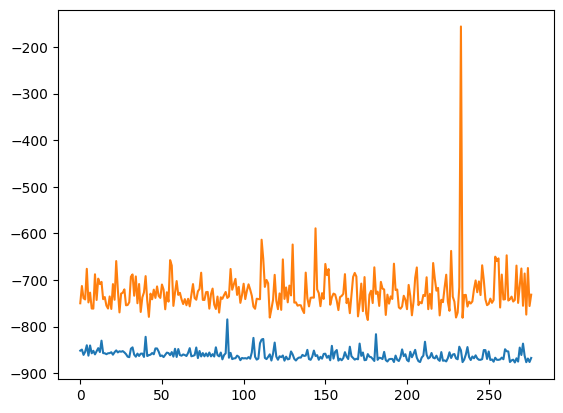

alpha 0.2 vae_lr 0.0005


In [17]:

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
print("alpha",alpha, "vae_lr", vae_lr)
# plt.ylim([-2000, 1000])

In [18]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_data_fixlen()
# simdata0d = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_data_fixlen()
# simdata0e = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 
#     ax_list[-1].plot(simdata0d[i][:,0], simdata0d[i][:,1]) 
#     ax_list[-1].plot(simdata0e[i][:,0], simdata0e[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"iter1.png")
plt.savefig(figfilenamehead+"iter1.eps")
plt.savefig(figfilenamehead+"iter1.pdf")
print("実環境方策rollout vs Sim環境方策rollout")


 0
get_belief:  [-1.9474657 -6.3514237] iter 85 len 200 compute_time 0.0644 best_loss -1.02e+03 loss.item() -1.02e+03        
 1
get_belief:  [-1.4606338 -7.565518 ] iter 74 len 200 compute_time 0.0544 best_loss -1.01e+03 loss.item() -1.01e+03        
 2
get_belief:  [-1.5725735 -8.013581 ] iter 67 len 200 compute_time 0.0502 best_loss -1.03e+03 loss.item() -1.03e+03        
 3
get_belief:  [-1.342085  -7.7929964] iter 67 len 200 compute_time 0.0532 best_loss -1.06e+03 loss.item() -1.05e+03        
 4
get_belief:  [-1.7164451 -7.926953 ] iter 181 len 200 compute_time 0.115 best_loss -1e+03 loss.item() -1e+03       
 5
get_belief:  [-0.993853  -8.0686035] iter 66 len 200 compute_time 0.0483 best_loss -951 loss.item() -951          
 6
get_belief:  [-2.0295274 -6.9674063] iter 76 len 200 compute_time 0.0554 best_loss -1.03e+03 loss.item() -1.03e+03       
 7
get_belief:  [-1.7591987 -8.03486  ] iter 81 len 200 compute_time 0.0592 best_loss -1.02e+03 loss.item() -1.02e+03       
 8
get_b

get_belief:  [-1.3376881 -7.448621 ] iter 100 len 200 compute_time 0.0743 best_loss -1.02e+03 loss.item() -1.02e+03       
 66
get_belief:  [-1.0616536 -8.291889 ] iter 93 len 200 compute_time 0.0676 best_loss -966 loss.item() -966         
 67
get_belief:  [-1.8859674 -6.7845335] iter 83 len 200 compute_time 0.0606 best_loss -1.04e+03 loss.item() -1.04e+03        
 68
get_belief:  [-1.9176145 -5.4638   ] iter 56 len 200 compute_time 0.0433 best_loss -1.03e+03 loss.item() -1.03e+03       
 69
get_belief:  [-1.7220167 -8.299216 ] iter 69 len 200 compute_time 0.0509 best_loss -1.03e+03 loss.item() -1.03e+03       
 70
get_belief:  [-1.7372518 -8.20667  ] iter 90 len 200 compute_time 0.0653 best_loss -1.02e+03 loss.item() -1.02e+03        
 71
get_belief:  [-1.1597576 -9.995708 ] iter 57 len 200 compute_time 0.0411 best_loss -1.01e+03 loss.item() -1.01e+03       
 72
get_belief:  [-1.8984365 -6.8450346] iter 103 len 200 compute_time 0.0757 best_loss -1.01e+03 loss.item() -1.01e+03       


get_belief:  [-1.1978141 -9.57331  ] iter 86 len 200 compute_time 0.0655 best_loss -1.01e+03 loss.item() -1.01e+03       
 31
get_belief:  [-1.8640928 -6.868672 ] iter 59 len 200 compute_time 0.0432 best_loss -1.05e+03 loss.item() -1.05e+03        
 32
get_belief:  [ -1.1169655 -10.461039 ] iter 67 len 200 compute_time 0.0486 best_loss -1.02e+03 loss.item() -1.02e+03       
 33
get_belief:  [-1.8942456 -6.2084513] iter 60 len 200 compute_time 0.0437 best_loss -1.04e+03 loss.item() -1.04e+03        
 34
get_belief:  [-0.96487623 -7.959559  ] iter 112 len 200 compute_time 0.0795 best_loss -921 loss.item() -920        
 35
get_belief:  [-0.97819513 -7.8609357 ] iter 55 len 200 compute_time 0.0427 best_loss -934 loss.item() -934         
 36
get_belief:  [-1.3548669 -7.8268776] iter 104 len 200 compute_time 0.0755 best_loss -1.03e+03 loss.item() -1.02e+03       
 37
get_belief:  [-0.95087266 -8.015746  ] iter 126 len 200 compute_time 0.09 best_loss -936 loss.item() -936          
 38
get_b

get_belief:  [-1.0292139 -8.222103 ] iter 133 len 200 compute_time 0.0883 best_loss -968 loss.item() -967          
 96
get_belief:  [-1.9559015 -6.480166 ] iter 73 len 200 compute_time 0.0534 best_loss -1.02e+03 loss.item() -1.02e+03       
 97
get_belief:  [-1.5481541 -9.174393 ] iter 78 len 200 compute_time 0.0395 best_loss -1.02e+03 loss.item() -1.01e+03       
 98
get_belief:  [-1.7470208 -8.171186 ] iter 70 len 200 compute_time 0.0583 best_loss -1.03e+03 loss.item() -1.03e+03        
 99
 et_belief:  [-1.1952606 -8.232584 ] iter 65 len 200 compute_time 0.0476 best_loss -1.04e+03 loss.item() -1.04e+03        

 0
get_belief:  [-1.8907542 -6.384877 ] iter 151 len 200 compute_time 0.0953 best_loss -1.01e+03 loss.item() -1.01e+03       
 1
get_belief:  [-1.2836525 -7.8200293] iter 93 len 200 compute_time 0.0681 best_loss -1.02e+03 loss.item() -1.02e+03        
 2
get_belief:  [-1.6030239 -8.184576 ] iter 76 len 200 compute_time 0.0559 best_loss -1.05e+03 loss.item() -1.05e+03       


In [19]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter1.png")
plt.savefig(figfilenamehead+"damping_latent_iter1.eps")
plt.savefig(figfilenamehead+"damping_latent_iter1.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])
# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [20]:
print(datetime.datetime.now())

# Iter2

In [21]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [22]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)


In [23]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [24]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter2.png")

In [25]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
# #     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [26]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
# #     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [27]:

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()


print("alpha",alpha, "vae_lr", vae_lr)
# plt.ylim([-2000, 1000])

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"joint_iter2.png")
plt.savefig(figfilenamehead+"joint_iter2.eps")
plt.savefig(figfilenamehead+"joint_iter2.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter2.png")
plt.savefig(figfilenamehead+"damping_latent_iter2.eps")
plt.savefig(figfilenamehead+"damping_latent_iter2.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])
# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

# Iter 3

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)



In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter3.png")

In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
# #     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
# #     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:
# i = 49
# plt.plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1])
# plt.plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
# # plt.plot(simdata1b[i][:,0], simdata1b[i][:,1]) 
# plt.scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()),
#            # vmin=f(min_val), vmax=f(max_val)
#            )
# plt.colorbar()

In [ ]:

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()

print("alpha",alpha, "vae_lr", vae_lr)
# plt.ylim([-2000, 1000])

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"joint_iter3.png")
plt.savefig(figfilenamehead+"joint_iter3.eps")
plt.savefig(figfilenamehead+"joint_iter3.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter3.png")
plt.savefig(figfilenamehead+"damping_latent_iter3.eps")
plt.savefig(figfilenamehead+"damping_latent_iter3.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])
# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

# Iter 4

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)


In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter4.png")

In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
# #     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
# #     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:
# i = 35
# plt.plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1])
# plt.plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
# # plt.plot(simdata1b[i][:,0], simdata1b[i][:,1]) 
# plt.scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()),
#            # vmin=f(min_val), vmax=f(max_val)
#            )
# plt.colorbar()

In [ ]:

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()

print("alpha",alpha, "vae_lr", vae_lr)
# plt.ylim([-2000, 1000])

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"joint_iter4.png")
plt.savefig(figfilenamehead+"joint_iter4.eps")
plt.savefig(figfilenamehead+"joint_iter4.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter4.png")
plt.savefig(figfilenamehead+"damping_latent_iter4.eps")
plt.savefig(figfilenamehead+"damping_latent_iter4.pdf")
plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])

# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

# Iter5

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)

In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
fig = plt.figure(figsize=(18,10), dpi=250)
ax_list = []
# min_val = min([iwvi.offlinedata_weight[i].min().numpy() for i in range(len(offline_data))])
# max_val = max([iwvi.offlinedata_weight[i].max().numpy() for i in range(len(offline_data))])
min_val = 1e-8
max_val = 1e3
print(min_val, max_val)

for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
    ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()), vmin=f(min_val), vmax=f(max_val), s=5) 
plt.savefig(figfilenamehead+"weight_iter5.png")

In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
# #     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:
# fig = plt.figure(figsize=(18,10))
# print(min_val, max_val)
# for i in range(len(offline_data)):
#     ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
#     ax_list[-1].set_xticks([])
#     ax_list[-1].set_yticks([])
# #     ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"k-")
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"rx")
#     ax_list[-1].scatter(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1], c=f(iwvi.offlinedata_weight[i].numpy()/iwvi.offlinedata_weight[i].numpy().sum()), vmin=f(min_val), vmax=f(max_val), s=5) 


In [ ]:

train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()
train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()


train_curve, valid_curve = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
iwvi.update_mulogvar_offlinedata()
plt.plot(train_curve)
plt.plot(valid_curve)
plt.show()

print("alpha",alpha, "vae_lr", vae_lr)
# plt.ylim([-2000, 1000])

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
    ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
plt.savefig(figfilenamehead+"joint_iter5.png")
plt.savefig(figfilenamehead+"joint_iter5.eps")
plt.savefig(figfilenamehead+"joint_iter5.pdf")

print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
plt.figure(figsize=(16,12))
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()


plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
plt.xlim([0,0.3])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_iter5.png")
plt.savefig(figfilenamehead+"damping_latent_iter5.eps")
plt.savefig(figfilenamehead+"damping_latent_iter5.pdf")

plt.show()

# plt.figure(figsize=(16,12))
# plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
# plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.plot([bif_c, bif_c],[np_mulogvar[:,0].min(),np_mulogvar[:,0].max()])
# for i in range(len(debug_info)):
#     plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
# plt.xlim([0.06,0.14])
# plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [ ]:
print(datetime.datetime.now())

# 評価関数計算

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()

In [ ]:
iwvi.train_ratio(num_iter=num_iter_max, lr=ratio_lr, early_stop_step=ratio_early, policy=agent.select_action)
iwvi.save()
# plt.plot(train_curve)
# plt.plot(valid_curve)

In [ ]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


In [ ]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=100)


In [ ]:
print(iwvi.initial_belief)
iwvi.save()

In [ ]:
loss_array = np.array(loss_list)

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.png")
plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.eps")
plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

In [ ]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")